In [269]:
import psycopg2
import math
import pandas
from pandas import *

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import brewer2mpl

In [76]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'solarized',
              'transition': 'default',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected',
 u'theme': 'solarized',
 u'transition': 'default'}

## Module 0: Background

* ### The dataset: www.airbnb.com
* ### Listing data (excludes reviews and indication of how frequently a listing is rented)
* ### Create a pricing model
 * #### Find over/undervalued properties
 * #### Spot opportunities as a host (renter)
* ### ~35k listings for NYC scraped using some python scripts I wrote
* ### Data is in one HAWQ table called listings

## Tools:

* ### HAWQ
 * #### SQL 
 * #### pgAdmin III
 * #### MADlib
 * #### PL/Python

* ### Python (Anaconda and the PyData Stack)
 * #### Jupyter notebook (with RISE/revealjs)
 * #### pandas (built on numpy)
 * #### seaborn (built on matplotlib)
 * #### scikit-learn (maybe)

### You might:

* #### have little/no experience with SQL

* #### have no experience with python

### That's okay because:

* #### This uses mostly basic features of SQL and python (and pandas)

* #### I will provide you with the data and the notebook so you can try it on your own

* #### There is lots of reusable code in what's to follow

* #### Abstraction!

* #### This is (almost) exactly how I picked up python (and pandas): https://www.youtube.com/watch?v=w26x-z-BdWQ

* #### Some cheatsheets: https://drive.google.com/drive/u/0/folders/0ByIrJAE4KMTtaGhRcXkxNHhmY2M

### The purpose of today: 

* #### Python alleviates some of SQL's pain points
 * #### intentional lack of abstraction (ANSI standard)
 * #### repetitiveness

* #### HAWQ enables python work on big data, easily

* #### demonstrate a repeatable, scalable workflow and framework for doing data science

## Your data starts like this:

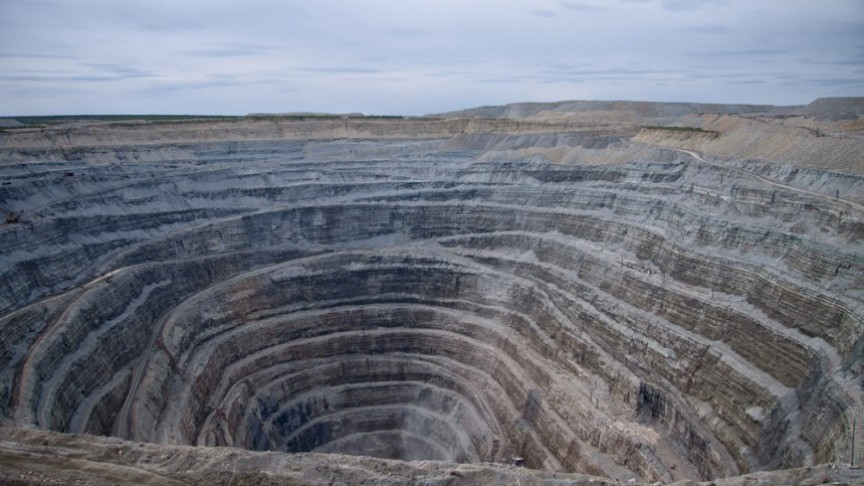

In [77]:
from IPython.display import Image
Image('http://www.miningglobal.com/public/uploads/large/large_Diamond_mine._.jpg', width='50%')

## HAWQ makes it like this:

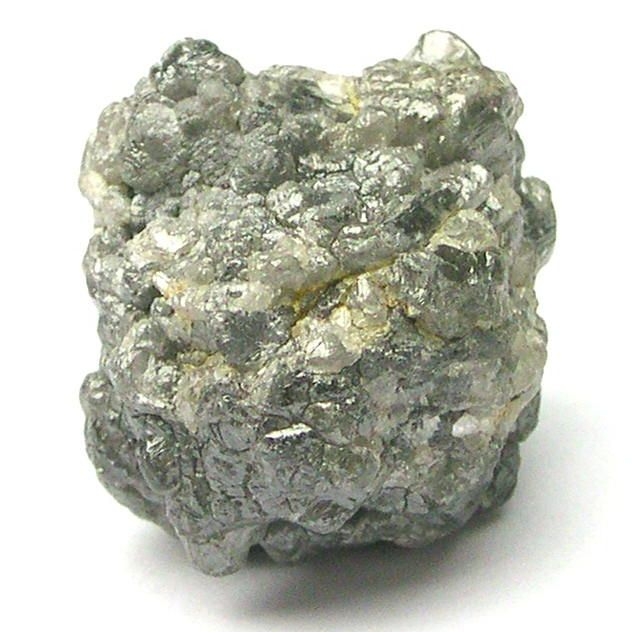

In [78]:
Image('https://s-media-cache-ak0.pinimg.com/736x/78/f6/4d/78f64d2b38e4bcf6336a319544bee8d3.jpg', width='30%')

## Python+HAWQ makes it like this:

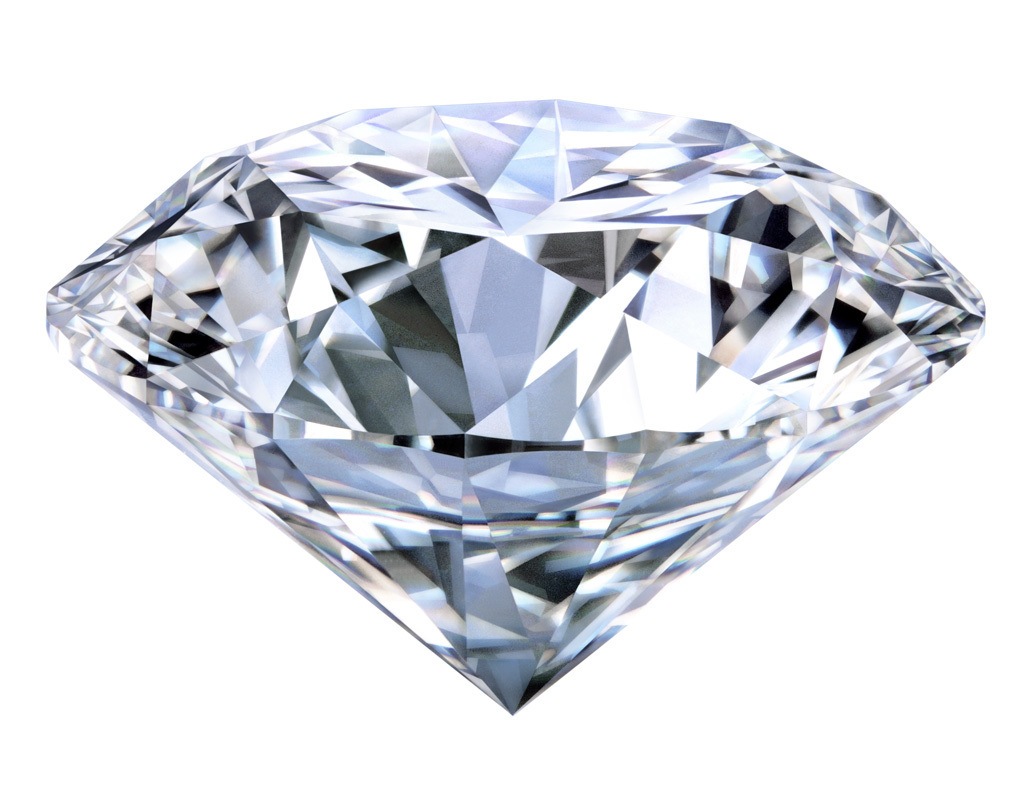

In [79]:
Image('http://www.j-beads.com/blog/wp-content/uploads/2013/06/diamond.jpg', width='30%')

## Module 1: Querying HAWQ via Python

In [277]:
conn = psycopg2.connect("""
host=localhost 
port=3005 
dbname=airbnb 
user=gpadmin 
password=gpadmin""") 
cur = conn.cursor()

In [81]:
query = 'SELECT COUNT(*) from listings'
cur.execute(query)
cur.fetchone()

(34429L,)

In [82]:
query = """
SELECT *
FROM listings
LIMIT 3"""
cur.execute(query)
print [desc[0] for desc in cur.description]

['lid', 'access', 'address', 'amenities', 'bathrooms', 'bed_type', 'bed_type_category', 'bedrooms', 'beds', 'calendar_updated_at', 'cancel_policy', 'cancel_policy_short_str', 'cancellation_policy', 'check_in_time', 'check_out_time', 'city', 'cleaning_fee_native', 'description', 'extra_user_info', 'extras_price_native', 'guests_included', 'has_agreed_to_legal_terms', 'has_availability', 'has_double_blind_reviews', 'has_viewed_terms', 'house_rules', 'instant_bookable', 'interaction', 'is_location_exact', 'lat', 'license', 'listing_cleaning_fee_native', 'listing_price_for_extra_person_native', 'listing_security_deposit_native', 'listing_weekend_price_native', 'lng', 'max_nights_input_value', 'min_nights_input_value', 'monthly_price_factor', 'monthly_price_native', 'name', 'neighborhood', 'neighborhood_overview', 'notes', 'person_capacity', 'picture_count', 'price', 'price_for_extra_person_native', 'property_type', 'require_guest_profile_picture', 'review_rating_accuracy', 'review_rating_c

In [83]:
row = cur.fetchone()
while row:
    print row
    row = cur.fetchone()
    break

(6029332, 'You have access to my room, my personal living room, the kitchen, the dining room, the stereotypical NY fire escape,  and both bathrooms.', 'Judge Street, Brooklyn, NY 11211, United States', 'Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Smoke Detector,Carbon Monoxide Detector,Essentials', 1.5, 'Real Bed', 'real_bed', 1, 2, '2 months ago', 3, 'Flexible', 'flexible', None, None, 'Brooklyn', None, "Renting my large bedroom in Williamsburg, Brooklyn. The room has it's own living room. The apartment is large and includes 1.5 bathrooms, a full kitchen, and dining room. It is located 2 blocks from the Grand Street L train.\n\nI will be out of town for a week in November so I am renting out my side which includes its own living room and, if you'd like, use of its own entrance. The king-size bed sleeps two and the pull out couch sleeps two as well.\n\nYou have access to my room, my personal living room, the kitchen, the dining room, the stereotypical NY fire escape,  a

## Module 2: using the Python library 'pandas' to
* #### Add functionality
* #### Improve the visual aspect (make tabular)

In [84]:
query = """
SELECT *
FROM listings
LIMIT 5"""
cur.execute(query)
DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

,lid,access,address,amenities,bathrooms,bed_type,bed_type_category,bedrooms,beds,calendar_updated_at,...,space,special_offer,square_feet,star_rating,summary,transit,user_id,weekly_price_factor,weekly_price_native,zipcode
0,6029332,"You have access to my room, my personal living...","Judge Street, Brooklyn, NY 11211, United States","Internet,Wireless Internet,Air Conditioning,Ki...",1.5,Real Bed,real_bed,1,2,2 months ago,...,I will be out of town for a week in November s...,None,None,5,"Renting my large bedroom in Williamsburg, Broo...","Extremely close to the L train, a subway line ...",1257611,0.85,684,11211
1,4325397,Trains close by. One stop to midtown Manhattan...,"Crescent Street, Queens, NY 11101, United States","Internet,Wireless Internet,Air Conditioning,Ki...",1.0,Real Bed,real_bed,1,1,5 days ago,...,Private room with lots of light. Brand New do...,None,None,NaN,For visitors on the budget with super short co...,Super convenient many trains. Q/N or 7 train ...,22460246,1.00,525,11101
2,6422551,You'll have access to the entire apartment: ba...,"Grattan Street, Brooklyn, NY 11237, United States","TV,Internet,Wireless Internet,Air Conditioning...",1.0,Real Bed,real_bed,1,1,7 months ago,...,"This is a cute bedroom with amazing, happy lig...",None,None,NaN,Cute and clean bedroom with lots of sun and gr...,We live two minutes from the L train at Morgan...,9072708,1.00,550,11237
3,6684697,"Guests have access to the apartment, the roof,...","Lorimer Street, Brooklyn, NY 11206, United States","TV,Cable TV,Internet,Wireless Internet,Air Con...",1.0,Real Bed,real_bed,1,1,5 days ago,...,The apartment faces the courtyard of the build...,None,None,5,A clean and modern apartment with enormous win...,"The apartment is a short walk from the L, J, M...",315082,1.00,NaN,11206
4,4587554,None,"Jay Ave, Maspeth, NY 11378, United States","TV,Internet,Wireless Internet,Air Conditioning...",1.0,Real Bed,real_bed,1,2,3 months ago,...,None,None,None,5,Our big 3 bedroom apt has a ton of sunlight th...,None,10258940,0.91,350,11378


### Code reusability: you can copy-paste this into your own scripts

In [368]:
def query(queries, return_data = True):
    results = []
    if type(queries) is str:
        queries = [queries]
    for q in queries:
        try:
            cur.execute(q)
        except Exception, e:
            print e
            conn.rollback()
            return None
        if return_data == True:
            try:
                results.append(DataFrame(cur.fetchall(), 
                    columns = [desc[0] for desc in cur.description]))
            except:
                pass
    conn.commit()
    if return_data == True:
        # for readability, 
        # only return df if length is 1
        if len(results) == 1:
            return results[0]
        return results

In [86]:
# top 5 neighborhoods by median price
q = """
SELECT bathrooms, bedrooms, COUNT(*), MEDIAN(price), AVG(price), MAX(price) 
FROM listings 
GROUP BY 1, 2
HAVING COUNT(*) > 100
ORDER BY 4 DESC
LIMIT 5
"""
query(q)

,bathrooms,bedrooms,count,median,avg,max
0,2.0,3,321,340.0,422.8753894081,6500
1,2.0,2,715,299.0,353.843356643357,2100
2,1.5,3,119,295.0,362.697478991597,4000
3,1.5,2,218,232.5,269.743119266055,2000
4,1.0,3,463,225.0,265.285097192225,2750


In [87]:
# top 5 neighborhoods by median price
q = """
SELECT neighborhood, count(*), median(price), avg(price), max(price) 
FROM listings 
GROUP BY 1 
ORDER BY 3 DESC
LIMIT 5
"""
query(q)

,neighborhood,count,median,avg,max
0,Tribeca,113,250.0,335.495575221239,1500
1,Midtown,290,223.5,294.044827586207,3000
2,Union Square,71,210.0,328.816901408451,2000
3,Noho,63,209.0,290.301587301587,1000
4,Times Square/Theatre District,111,205.0,275.441441441441,2000


## Organization 
* #### end goal
 * a logical workflow/pipeline
 * it should be trivial to re-create from the original database
* #### schemas: like a directory structure (can use prefix/suffix to create a tree-like structure)
* #### table naming: can also use prefix/suffix
* #### often start with a dev schema
* #### use git for collaboration and version control

In [93]:
q = ["""
DROP SCHEMA IF EXISTS dev CASCADE
""",
"""
CREATE SCHEMA dev
""",
"""
SET search_path TO "$user",public,dev
""",
"""
SHOW search_path
"""]
query(q)

,search_path
0,"""$user"", public, dev"


### Module 3: Intro to MADlib

#### standard syntax
```
SELECT madlib.<function>(
 'input_table',
 'output_table',
 'dependent_var', -- for supervised learning models
 'independent_var', -- for modeling
 'groupby_field', -- often used to generate models in parallel
 'algorithm_specific_params', -- 0 or more of these
 'optimization_algorithm'
```

### Why MADlib?
* #### simple to use
* #### pure in-database (why is this important?)
* #### parallel

### MADlib summary statistics
``` sql
SELECT madlib.summary(
'listings' -- input table
,'dev.x00000_listings_summary' -- output table (notice name)
,'price' -- statistics over what field?
)
```

In [94]:
q = ["""
DROP TABLE IF EXISTS dev.x00000_listings_summary
""",
     
     
"""
SELECT madlib.summary(
'listings' -- input table
,'dev.x00000_listings_summary' -- output table
,'price' -- statistics over what field?
)
""",
     
     
"""
SELECT *
FROM dev.x00000_listings_summary
"""
]
df = query(q)
df

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,price,47,int4,34429,507,0,None,0,None,149.356531,25282.50298,10,8000,75,115,180,"[150, 100, 200, 75, 50, 125, 80, 60, 65, 70]","[1643, 1425, 1080, 994, 969, 947, 946, 906, 86..."


### MADlib summary statistics (with groupby)
``` sql
SELECT madlib.summary(
'listings' -- input table
,'dev.x00001_listings_neighborhood_summary' -- output table
,'price' -- statistics over what field?
,'neighborhood' -- aggregate over neighborhood
)
```

In [95]:
# no need to do this manually: MADlib summary by price
# find which columns are interesting and which aren't
q = ["""
DROP TABLE IF EXISTS dev.x00001_listings_neighborhood_summary
""",
     
"""
SELECT madlib.summary(
'listings' -- input table
,'dev.x00001_listings_neighborhood_summary' -- output table
,'price' -- statistics over what field?
,'neighborhood' -- aggregate over neighborhood
)
""",
     
"""
SELECT *
FROM dev.x00001_listings_neighborhood_summary
ORDER BY median DESC
LIMIT 5
"""
]
query(q)

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,neighborhood,Tribeca,price,47,int4,113,70,0,None,0,None,335.495575,76244.734355,75,1500,150,250.0,400.00,"[250, 250, 250, 250, 250, 250, 500, 500, 500, ...","[7, 7, 7, 7, 7, 7, 6, 6, 6, 5]"
1,neighborhood,Midtown,price,47,int4,290,108,0,None,0,None,294.044828,72309.385527,50,3000,165,223.5,349.75,"[200, 200, 200, 200, 200, 200, 200, 200, 200, ...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16]"
2,neighborhood,Union Square,price,47,int4,71,48,0,None,0,None,328.816901,104047.494567,75,2000,181,210.0,337.50,"[200, 200, 200, 200, 200, 200, 200, 250, 225, ...","[7, 7, 7, 7, 7, 7, 7, 4, 4, 3]"
3,neighborhood,Noho,price,47,int4,63,40,0,None,0,None,290.301587,44660.117256,59,1000,165,209.0,350.00,"[200, 200, 200, 300, 300, 300, 300, 180, 180, ...","[5, 5, 5, 4, 4, 4, 4, 4, 4, 4]"
4,neighborhood,Times Square/Theatre District,price,47,int4,111,64,0,None,0,None,275.441441,63771.376085,58,2000,125,205.0,316.00,"[316, 316, 316, 316, 316, 316, 316, 316, 150, ...","[10, 10, 10, 10, 10, 10, 10, 10, 6, 6]"


## Module 4: Using Python to dynamically create queries:
* #### Use case: reuse code to get summary statistics over multiple columns

### Sidebar: string manipulation

In [96]:
print 'Let\'s analyze {0}'.format('bedrooms')

Let's analyze bedrooms


In [97]:
for c in ['bedrooms','bathrooms','beds']:
    print 'Let\'s analyze {0}'.format(c)

Let's analyze bedrooms
Let's analyze bathrooms
Let's analyze beds


In [98]:
for i, c in enumerate(['bedrooms','bathrooms','beds']):
    print '{1}: Let\'s analyze {0}'.format(c, i)

0: Let's analyze bedrooms
1: Let's analyze bathrooms
2: Let's analyze beds


In [99]:
for i, groupby in enumerate(['bedrooms','bathrooms','beds']):
    print """SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x0000{0}_listings_{1}_summary' -- output table
    ,'price' -- statistics over what field?
    ,'{1}' -- aggregate over groupby field
    )
    """.format(i+2, groupby)

SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00002_listings_bedrooms_summary' -- output table
    ,'price' -- statistics over what field?
    ,'bedrooms' -- aggregate over groupby field
    )
    
SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00003_listings_bathrooms_summary' -- output table
    ,'price' -- statistics over what field?
    ,'bathrooms' -- aggregate over groupby field
    )
    
SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00004_listings_beds_summary' -- output table
    ,'price' -- statistics over what field?
    ,'beds' -- aggregate over groupby field
    )
    


In [100]:
queries = []
outputs = []
# use python to loop over:
# say we want to look at stats over number of bathrooms, bedrooms, beds
for i, groupby in enumerate(['bedrooms','bathrooms','beds']):
    q = ["""
    DROP TABLE IF EXISTS dev.x0000{0}_listings_{1}_summary
    """.format(i+2, groupby),
    """
    SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x0000{0}_listings_{1}_summary' -- output table
    ,'price' -- statistics over what field?
    ,'{1}' -- aggregate over groupby field
    )
    """.format(i+2, groupby),
    """
    SELECT *
    FROM dev.x0000{0}_listings_{1}_summary
    WHERE row_count > 100
    ORDER BY median DESC
    LIMIT 5
    """.format(i+2, groupby)
    ]
    queries.append(q[1])
    outputs.append(query(q))

In [101]:
print queries[0]
outputs[0]


    SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00002_listings_bedrooms_summary' -- output table
    ,'price' -- statistics over what field?
    ,'bedrooms' -- aggregate over groupby field
    )
    


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,bedrooms,4,price,47,int4,236,93,0,None,0,None,478.711864,113320.180454,95,3000,275,399.5,556.25,"[400, 350, 300, 250, 500, 450, 199, 550, 800, ...","[13, 13, 12, 9, 9, 9, 7, 6, 6, 5]"
1,bedrooms,3,price,47,int4,1051,214,0,None,0,None,358.304472,152266.274828,60,6500,195,280.0,400.00,"[300, 250, 200, 350, 150, 400, 275, 500, 175, ...","[57, 54, 44, 40, 37, 33, 28, 27, 25, 24]"
2,bedrooms,2,price,47,int4,4182,355,0,None,0,None,241.838116,32489.949630,37,3750,150,200.0,284.75,"[150, 200, 250, 300, 175, 225, 350, 125, 180, ...","[250, 245, 241, 165, 121, 97, 95, 93, 90, 90]"
3,bedrooms,None,price,47,int4,3027,218,0,None,0,None,159.863892,9566.326478,35,2500,110,150.0,186.50,"[150, 200, 100, 175, 125, 120, 110, 130, 99, 180]","[274, 146, 140, 115, 106, 104, 88, 81, 76, 75]"
4,None,None,price,47,int4,34429,507,0,None,0,None,149.356531,25282.502980,10,8000,75,115.0,180.00,"[150, 100, 200, 75, 50, 125, 80, 60, 65, 70]","[1643, 1425, 1080, 994, 969, 947, 946, 906, 86..."


In [102]:
print queries[1]
outputs[1]


    SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00003_listings_bathrooms_summary' -- output table
    ,'price' -- statistics over what field?
    ,'bathrooms' -- aggregate over groupby field
    )
    


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,bathrooms,2.5,price,47,int4,264,109,0,None,0,None,355.306818,95321.703984,30,2000,119.75,288.5,496,"[500, 350, 250, 40, 450, 600, 400, 325, 275, 50]","[10, 10, 9, 8, 8, 8, 7, 7, 5, 5]"
1,bathrooms,3,price,47,int4,203,88,0,None,0,None,354.295567,209797.724089,30,3750,70.00,200.0,450,"[50, 70, 60, 300, 75, 100, 135, 65, 450, 250]","[9, 9, 8, 7, 6, 5, 5, 5, 5, 5]"
2,bathrooms,2,price,47,int4,2409,314,0,None,0,None,247.061021,88250.966790,11,6500,75.00,160.0,325,"[250, 150, 300, 60, 50, 350, 100, 200, 70, 400]","[73, 66, 64, 58, 57, 57, 57, 56, 52, 48]"
3,None,None,price,47,int4,34429,507,0,None,0,None,149.356531,25282.502980,10,8000,75.00,115.0,180,"[150, 100, 200, 75, 50, 125, 80, 60, 65, 70]","[1643, 1425, 1080, 994, 969, 947, 946, 906, 86..."
4,bathrooms,1,price,47,int4,29470,416,0,None,0,None,136.372548,11930.908846,10,5000,75.00,115.0,175,"[150, 100, 200, 125, 75, 80, 50, 60, 120, 65]","[1511, 1296, 965, 883, 870, 821, 816, 761, 761..."


In [103]:
print queries[2]
outputs[2]


    SELECT madlib.summary(
    'listings' -- input table
    ,'dev.x00004_listings_beds_summary' -- output table
    ,'price' -- statistics over what field?
    ,'beds' -- aggregate over groupby field
    )
    


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,beds,6,price,47,int4,184,105,0,None,0,None,396.809783,193598.766898,25,3750,150.75,299.5,456.25,"[350, 250, 29, 500, 400, 399, 300, 1000, 99, 69]","[8, 7, 6, 6, 6, 6, 5, 5, 4, 4]"
1,beds,5,price,47,int4,296,121,0,None,0,None,404.425676,438892.794457,11,8000,180.00,275.0,419.25,"[300, 200, 250, 400, 450, 500, 180, 175, 150, ...","[15, 14, 13, 10, 9, 9, 7, 7, 7, 7]"
2,beds,4,price,47,int4,845,197,0,None,0,None,294.777515,128479.054707,19,6500,139.00,220.0,350.00,"[150, 200, 250, 350, 300, 450, 275, 29, 225, 125]","[32, 31, 30, 28, 25, 22, 21, 20, 19, 17]"
3,beds,3,price,47,int4,2286,302,0,None,0,None,239.818460,41048.973156,25,4000,130.00,195.0,298.00,"[150, 250, 200, 300, 100, 125, 350, 175, 120, 99]","[118, 98, 94, 81, 70, 53, 52, 46, 42, 41]"
4,beds,2,price,47,int4,7367,361,0,None,0,None,181.255735,24023.221857,20,5000,100.00,150.0,210.00,"[150, 200, 250, 100, 175, 125, 120, 300, 110, 99]","[457, 344, 271, 267, 216, 213, 181, 155, 144, ..."


### SQL Engine + Python for Automation = Efficient Data Analysis

### String manipulation for repeatable tasks over many columns

#### Number of unique values by column:

In [104]:
# get columns
q = "SELECT * FROM listings LIMIT 1"
columns = query(q).columns

In [105]:
%%time
# iterate over columns to generate an SQL query

q = 'SELECT '
for c in columns:
    q += 'COUNT(DISTINCT {0}) AS {0},\n'.format(c)
q = q[:-1] + ' FROM listings'
print q[:100], '\n...\n', q[-100:]

SELECT COUNT(DISTINCT lid) AS lid,
COUNT(DISTINCT access) AS access,
COUNT(DISTINCT address) AS addr 
...
TINCT weekly_price_native) AS weekly_price_native,
COUNT(DISTINCT zipcode) AS zipcode, FROM listings
CPU times: user 133 µs, sys: 20 µs, total: 153 µs
Wall time: 144 µs


#### Sidebar: quick lesson in list comprehension

In [106]:
print [c for c in columns][:5]

['lid', 'access', 'address', 'amenities', 'bathrooms']


In [107]:
# using only first 2
print ['COUNT(DISTINCT {0}) AS {0},\n'.format(c) for c in columns][:2]

['COUNT(DISTINCT lid) AS lid,\n', 'COUNT(DISTINCT access) AS access,\n']


In [108]:
print '\n'.join(['COUNT(DISTINCT {0}) AS {0},'.format(c) for c in columns])[:100],'...'

COUNT(DISTINCT lid) AS lid,
COUNT(DISTINCT access) AS access,
COUNT(DISTINCT address) AS address,
CO ...


In [109]:
q = 'SELECT ' + '\n'.join(['COUNT(DISTINCT {0}) AS {0},'.format(c) for c in columns])[:-2] + \
                            '\n FROM listings \n'
distinct_counts = query(q)

In [110]:
distinct_counts

,lid,access,address,amenities,bathrooms,bed_type,bed_type_category,bedrooms,beds,calendar_updated_at,...,space,special_offer,square_feet,star_rating,summary,transit,user_id,weekly_price_factor,weekly_price_native,zipcod
0,34429,19145,6621,23409,13,5,5,10,14,57,...,25676,0,148,8,30969,20852,28149,108,937,184


### Break task: use list comprehension to sketch a way to count the number of null values

In [111]:
q = 'SELECT ' + '\n'.join(['COUNT(lid) - COUNT({0}) AS {0},'.format(c) \
                           for c in columns])[:-2] + '\n FROM listings \n'
null_counts = query(q)

In [112]:
null_counts

,lid,access,address,amenities,bathrooms,bed_type,bed_type_category,bedrooms,beds,calendar_updated_at,...,space,special_offer,square_feet,star_rating,summary,transit,user_id,weekly_price_factor,weekly_price_native,zipcod
0,0,13322,0,571,392,0,0,3027,86,0,...,8115,34429,33724,15720,2418,11918,0,11555,20661,209


### Breaktime pandas tip: transpose and name the index and column

In [113]:
distinct_counts = distinct_counts.T
distinct_counts.head()

,0
lid,34429
access,19145
address,6621
amenities,23409
bathrooms,13


In [114]:
distinct_counts.columns = ['counts']
distinct_counts.index.name = 'column'
distinct_counts.head()

,counts
column,
lid,34429
access,19145
address,6621
amenities,23409
bathrooms,13


In [115]:
null_counts = null_counts.T
null_counts.head()
null_counts.columns = ['null']
null_counts.index.name = 'column'
null_counts.head()

,null
column,
lid,0
access,13322
address,0
amenities,571
bathrooms,392


#### We could query this using a join in SQL, but since the data are already small, we can use pandas to make a SQL-style join:
```
left.merge(right, <--- join 2 tables i.e. dataframes
       left_index/left_on, right_index/right_on, <--- join indexes or columns?
       how) <--- left, right, outer join?
```

In [116]:
distinct_counts = distinct_counts.merge(null_counts, left_index = True, right_index = True)
distinct_counts.head()

,counts,null
column,,
lid,34429,0
access,19145,13322
address,6621,0
amenities,23409,571
bathrooms,13,392


## Module 5: assessing the usefulness of the columns
* #### Numerical values that are too small may not have enough variance to be predictive. Values that are too high might include  some text fields that require parsing. Values with lots of nulls are difficult to use in a ML model

* #### HAWQ includes some useful tables to query for metadata

In [117]:
q = """
SELECT column_name, data_type FROM information_schema.columns
WHERE table_name = 'listings'
"""
datatypes = query(q)
datatypes.head(2)

,column_name,data_type
0,require_guest_profile_picture,boolean
1,is_location_exact,boolean


#### Pandas tip: set index

In [118]:
datatypes.set_index('column_name', inplace = True)
datatypes.head(2)

,data_type
column_name,
require_guest_profile_picture,boolean
is_location_exact,boolean


#### Merge in the data types

In [119]:
distinct_counts = distinct_counts.merge(datatypes, left_index=True, right_index=True)
distinct_counts.head()

,counts,null,data_type
require_guest_profile_picture,1,32621,boolean
is_location_exact,1,4478,boolean
instant_bookable,1,30264,boolean
has_viewed_terms,1,10970,boolean
has_availability,1,0,boolean


### We can now start categorizing columns into usefulness and datatypes
* #### Useless: 0 or 1 unique values
* #### Many nulls: 50% null values
* #### Requires text parsing: text field with many values
* #### Categorical: mostly text fields with relatively few values, e.g. neibhborhood
* #### Discrete: mostly integers, e.g. number of bedrooms
* #### Continuous: floats with many values

#### Pandas tip: filter

In [120]:
distinct_counts[distinct_counts.counts <= 1]

,counts,null,data_type
require_guest_profile_picture,1,32621,boolean
is_location_exact,1,4478,boolean
instant_bookable,1,30264,boolean
has_viewed_terms,1,10970,boolean
has_availability,1,0,boolean
has_agreed_to_legal_terms,1,2915,boolean
special_offer,0,34429,text
license,0,34429,text
has_double_blind_reviews,0,34429,text
extra_user_info,0,34429,text


#### Get columns (the index)

In [121]:
list(distinct_counts[distinct_counts.counts <= 1].index)

['require_guest_profile_picture',
 'is_location_exact',
 'instant_bookable',
 'has_viewed_terms',
 'has_availability',
 'has_agreed_to_legal_terms',
 'special_offer',
 'license',
 'has_double_blind_reviews',
 'extra_user_info']

### Pandas tips: take a slice of a dataframe; add a column
```
df.loc[row_name, col_name]        # get value of cell
df.loc[row_name, col_name] = val  # set value of cell
```

In [122]:
distinct_counts.loc[list(distinct_counts[distinct_counts.counts <= 1].index), 'col_type'] = 'useless'
distinct_counts.head()

,counts,null,data_type,col_type
require_guest_profile_picture,1,32621,boolean,useless
is_location_exact,1,4478,boolean,useless
instant_bookable,1,30264,boolean,useless
has_viewed_terms,1,10970,boolean,useless
has_availability,1,0,boolean,useless


### Next type: requires text parsing
* #### anything over 1000 falls into this category
* #### anything property_type (count=21) and under is categorical
* #### we know neighborhood is categorical
* #### calendar_updated_at is related to time data, which we don't have. we can add it to useless

In [123]:
remaining = distinct_counts[distinct_counts.col_type.isnull()]
remaining.head(10)

,counts,null,data_type,col_type
weekly_price_native,937,20661,integer,NaN
user_id,28149,0,integer,NaN
square_feet,148,33724,integer,NaN
security_price_native,202,18781,integer,NaN
security_deposit_native,202,18781,integer,NaN
reviews_count,220,8734,integer,NaN
review_rating_value,9,9437,integer,NaN
review_rating_location,9,9430,integer,NaN
review_rating_communication,9,9326,integer,NaN
review_rating_cleanliness,9,9341,integer,NaN


* #### it is unclear what city and smart_location are so we can look at those vaules

In [124]:
for c in ['smart_location', 'city']:
    print query('SELECT DISTINCT(' + c + ') FROM listings').head(10)

                       smart_location
0              Queens - Sunnyside, NY
1                 Rockaway Beach , NY
2                        brooklyn, NY
3                       Woodhaven, NY
4  Brooklyn Heights, Brooklyn NYC, NY
5                    East Elmhust, NY
6                        Elmhurst, NY
7                LONG ISLAND CITY, NY
8                     Astoria/LIC, NY
9            Greenpoint, Brooklyn, NY
                             city
0                              Bk
1                     kew gardens
2   Carroll Gardens,Brooklyn, NYC
3  Brooklyn Heights, Brooklyn NYC
4                   New York City
5                       Brookyln 
6                 Jackson Heights
7                       Brooklyn 
8                      Ozone Park
9                       New york 


#### This data is redundant with neighorhood, so we can add it to useless.

In [125]:
distinct_counts.loc[['city', 'smart_location', 'calendar_updated_at'], 'col_type'] = 'useless'
remaining = distinct_counts[distinct_counts.col_type.isnull()]

* #### set counts > 21 to text_field
* #### set counts <= 21 to categorical

In [126]:
distinct_counts.loc[list(remaining[(remaining.data_type=='text') & \
                        (remaining.counts > 21)].index.values), \
                    'col_type'] = 'text_field'
distinct_counts.loc[list(remaining[(remaining.data_type=='text') & \
                        (remaining.counts <= 21)].index.values), \
                    'col_type'] = 'categorical'
distinct_counts.loc['neighborhood', 'col_type'] = 'categorical'

### Should we start moving faster?

* #### Peak at the remaining ones

In [127]:
remaining = distinct_counts[distinct_counts.col_type.isnull()]
remaining.sort_values(by='counts', ascending = False).head(10)

,counts,null,data_type,col_type
lat,34429,0,double precision,NaN
lng,34429,0,double precision,NaN
lid,34429,0,integer,NaN
user_id,28149,0,integer,NaN
weekly_price_native,937,20661,integer,NaN
price,507,0,integer,NaN
listing_weekend_price_native,329,27624,integer,NaN
reviews_count,220,8734,integer,NaN
max_nights_input_value,204,12138,integer,NaN
security_deposit_native,202,18781,integer,NaN


#### Arbitrary, but use count of 20 as the separator between discrete and continuous

In [128]:
distinct_counts.loc[list(remaining[remaining.counts > 20].index.values), \
                    'col_type'] = 'continuous'
distinct_counts.loc[list(remaining[remaining.counts <= 20].index.values), \
                    'col_type'] = 'discrete'

In [129]:
distinct_counts[distinct_counts.col_type.isnull()]

,counts,null,data_type,col_type


#### Discrete, continuous, categorical are the useful ones

In [130]:
potentially_useful_columns = distinct_counts[distinct_counts.col_type.apply(lambda x: \
            True if x in ['discrete','continuous','categorical'] else False)]

### At this point, it may be easy to use Excel to select which columns to focus on
* #### Pandas tip: write to csv (xlsx workbook is possible too)

In [131]:
potentially_useful_columns.to_csv('potentially_useful_columns.csv')
potentially_useful_columns.head()

,counts,null,data_type,col_type
weekly_price_native,937,20661,integer,continuous
user_id,28149,0,integer,continuous
square_feet,148,33724,integer,continuous
security_price_native,202,18781,integer,continuous
security_deposit_native,202,18781,integer,continuous


### This required some manual intervention since it is not an exact science
* #### Not ideal!

In [132]:
keepers = ['room_type_category',
'bed_type_category',
'cancellation_policy',
'star_rating',
'bedrooms',
'bathrooms',
'beds',
'guests_included',
'person_capacity',
'property_type',
'min_nights_input_value',
'listing_price_for_extra_person_native',
'picture_count',
'neighborhood',
'listing_cleaning_fee_native',
'extras_price_native',
'listing_security_deposit_native',
'security_deposit_native',
'max_nights_input_value',
'reviews_count',
'listing_weekend_price_native',
'price',
'weekly_price_native']

In [133]:
useful_columns = potentially_useful_columns.loc[keepers, :]
useful_columns

,counts,null,data_type,col_type
room_type_category,3,0,text,categorical
bed_type_category,5,0,text,categorical
cancellation_policy,6,0,text,categorical
star_rating,8,15720,double precision,discrete
bedrooms,10,3027,integer,discrete
bathrooms,13,392,double precision,discrete
beds,14,86,integer,discrete
guests_included,15,628,integer,discrete
person_capacity,16,0,integer,discrete
property_type,21,2,text,categorical


# Let's take a break

### questions? comments? whiteboard?

## Module 6: plot the data using seaborn

### Going forward: if you have an idea of a visualization, let me know and we can try it!

In [134]:
sns.set_style('darkgrid')
sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 0})

### SQL sidebar: case statements 
* #### if-then-else
* #### in lieu of attribute in SELECT clause
``` sql
CASE WHEN <T/F condition> THEN <value>
  WHEN <T/F condition> THEN <value> -- analogous to else-if
  ...
  WHEN <T/F condition> THEN <value> -- 0 or more these
  ELSE <value> 
  END -- don't forget this
  AS <name> -- name your creation
```

``` sql
SELECT CASE WHEN price < summary.first_quartile THEN 1 
  WHEN price < summary.median THEN 2 
  WHEN price < summary.third_quartile THEN 3
  ELSE 4 END AS price_quartile 
FROM listings, dev.x00000_listings_summary summary -- MADlib summary table from before
```

In [135]:
q = """
SELECT bathrooms, bedrooms, beds,
  CASE WHEN price < summary.first_quartile THEN 1 
  WHEN price < summary.median THEN 2 
  WHEN price < summary.third_quartile THEN 3
  ELSE 4 END AS price_quartile 
FROM listings, dev.x00000_listings_summary summary
"""
df = query(q).dropna()
df.head()

,bathrooms,bedrooms,beds,price_quartile
0,1.5,1,2,2
1,1.0,1,1,2
2,1.0,1,1,2
3,1.0,1,1,3
4,1.0,1,2,1


### Behond the power of abstraction:

/Users/jplotkin/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


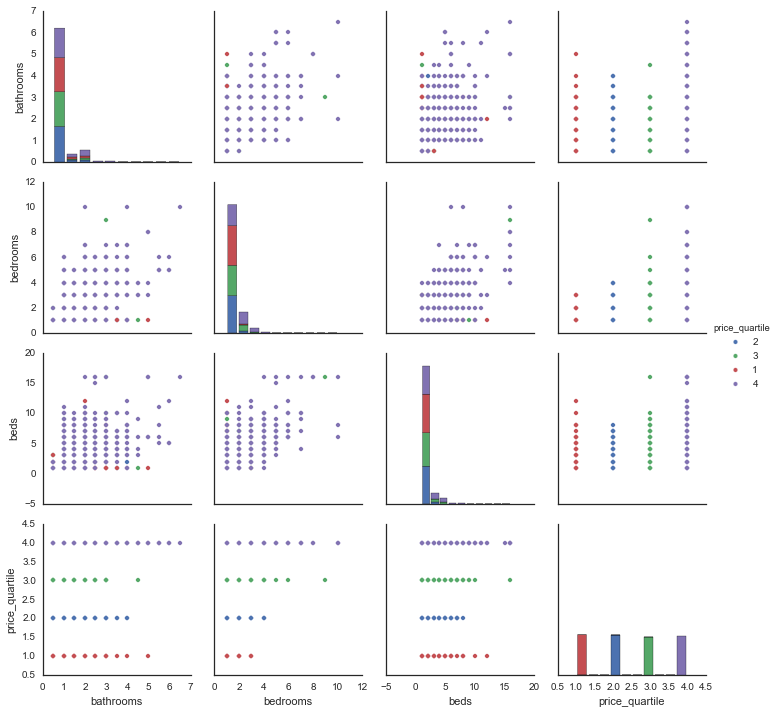

In [136]:
sns.pairplot(df, hue="price_quartile")

### Customize the plot
* #### fix ordering of legend (hue_order)
* #### use price only for color (vars)
* #### add regression lines (kind)
* #### choose different colors (palette)
* #### add opacity (plot_kws --> alpha)

```python
sns.pairplot(df, hue="price_quartile"
             , hue_order = [1,2,3,4]
             , vars = ['bedrooms', 'bathrooms', 'beds']   
             , plot_kws={'scatter_kws': {'alpha':0.5, 's':15},
                        'line_kws': {'alpha':0.5}}
             , kind = 'reg'
             , palette='BrBG')
```             

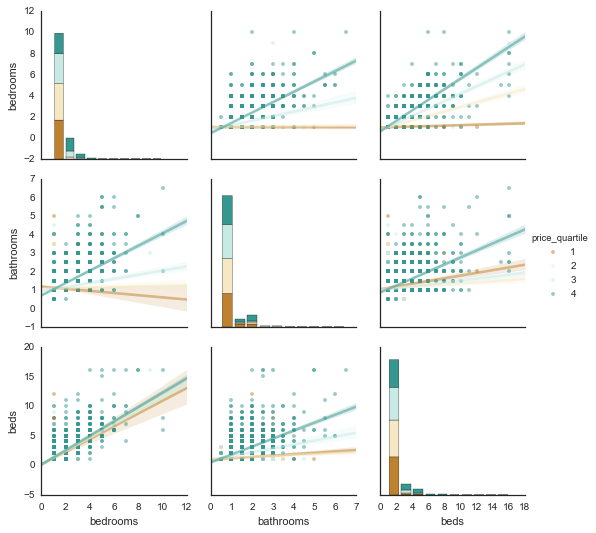

In [137]:
sns.pairplot(df, hue="price_quartile"
             , hue_order = [1,2,3,4]
             , vars = ['bedrooms', 'bathrooms', 'beds']   
             , plot_kws={'scatter_kws': {'alpha':0.5, 's':15},
                        'line_kws': {'alpha':0.5}}
             , kind = 'reg'
             , palette='BrBG')

### Add jitter using SQL
* #### What is jitter
* #### Why do we add jitter?
* #### postgres ```random()``` samples from Unif(0,1)
* #### How to add jitter (offset and scale):
```sql
bathrooms + (random()-0.5)*0.5
```

#### Looks scary, but same as previous, plus jitter...

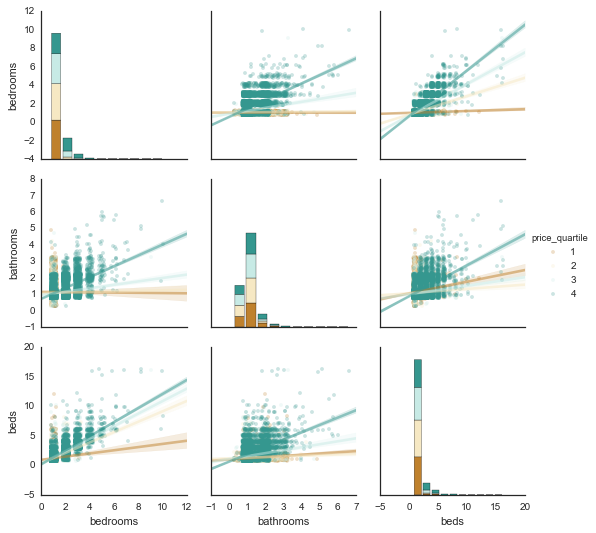

In [138]:
q = """
SELECT bathrooms + (random()-0.5)*0.5 AS bathrooms, 
  bedrooms + (random()-0.5)*0.5 AS bedrooms, 
  beds + (random()-0.5)*0.5 AS beds,
  CASE WHEN price < summary.first_quartile THEN 1
  WHEN price < summary.median THEN 2
  WHEN price < summary.third_quartile THEN 3
  ELSE 4 END AS price_quartile 
FROM listings, dev.x00000_listings_summary summary
"""
df_jitter = query(q).dropna()
sns.pairplot(df_jitter
             , hue="price_quartile"
             , hue_order = [1,2,3,4]
             , vars = ['bedrooms', 'bathrooms', 'beds']   
             , plot_kws={'line_kws': {'alpha':0.5},
                         'scatter_kws': {'alpha':0.25, 's':15}}
             , kind = 'reg'
             , palette='BrBG')

#### Naively plot data -- run into a problem of sample size

In [139]:
q = """
SELECT price, bathrooms, beds, bedrooms
FROM listings
"""
df_raw = query(q).dropna()
df_raw.head()

,price,bathrooms,beds,bedrooms
0,110,1.5,2,1
1,75,1.0,1,1
2,75,1.0,1,1
3,145,1.0,1,1
4,55,1.0,2,1


In [140]:
# g = sns.FacetGrid(df_raw, col="beds")
# g.map(plt.hist, "price")

## Module 7: common workflows

* ### A common workflow: let HAWQ crunch the raw data, receive a small amount of data to your laptop, then manipulate/plot the smaller data
* ### We can compare the process time and size of the output for the 2 workflows:

#### Query all data, then plot the raw data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34429 entries, 0 to 34428
Data columns (total 1 columns):
bathrooms    34037 non-null float64
dtypes: float64(1)
memory usage: 538.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34429 entries, 0 to 34428
Data columns (total 1 columns):
bathrooms    34037 non-null float64
dtypes: float64(1)
memory usage: 538.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34429 entries, 0 to 34428
Data columns (total 1 columns):
bathrooms    34037 non-null float64
dtypes: float64(1)
memory usage: 538.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34429 entries, 0 to 34428
Data columns (total 1 columns):
bathrooms    34037 non-null float64
dtypes: float64(1)
memory usage: 538.0 KB
None
1 loops, best of 3: 2.64 s per loop


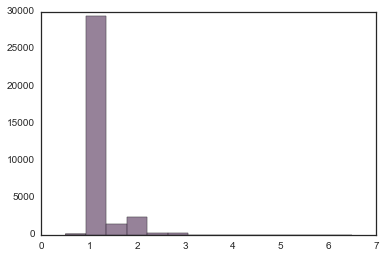

In [141]:
%%timeit

q = """
SELECT bathrooms
FROM listings
""".format(c)
df = query(q)
print df.info()
sns.distplot(df.dropna(), kde=False, bins = 14)

#### Let HAWQ aggregate the data, then plot it (plot is the same)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
bathrooms    13 non-null float64
samples      14 non-null int64
dtypes: float64(1), int64(1)
memory usage: 336.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
bathrooms    13 non-null float64
samples      14 non-null int64
dtypes: float64(1), int64(1)
memory usage: 336.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
bathrooms    13 non-null float64
samples      14 non-null int64
dtypes: float64(1), int64(1)
memory usage: 336.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
bathrooms    13 non-null float64
samples      14 non-null int64
dtypes: float64(1), int64(1)
memory usage: 336.0 bytes
None
1 loops, best of 3: 1.7 s per loop


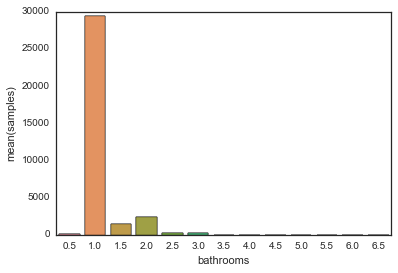

In [142]:
%%timeit

q = """
SELECT bathrooms, count(*) as samples
FROM listings
GROUP BY 1
ORDER BY 1
"""
df = query(q)
print df.info()
sns.barplot(x="bathrooms", y="samples", data=df)

### Use string manipulations to get count and median price by category

In [143]:
dfs = []
for c in ['bathrooms', 'beds', 'bedrooms']:
    q = """
    SELECT {0}, count(*) as samples, median(price) as med_price
    FROM listings
    GROUP BY 1
    ORDER BY 1
    """.format(c)
    dfs.append(query(q).dropna())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 3 columns):
bathrooms    13 non-null float64
samples      13 non-null int64
med_price    13 non-null float64
dtypes: float64(2), int64(1)
memory usage: 416.0 bytes
None


,bathrooms,samples,med_price
0,0.5,122,80.0
1,1.0,29470,115.0
2,1.5,1507,99.0
3,2.0,2409,160.0
4,2.5,264,288.5
5,3.0,203,200.0
6,3.5,24,550.0
7,4.0,20,377.5
8,4.5,5,700.0
9,5.0,5,800.0


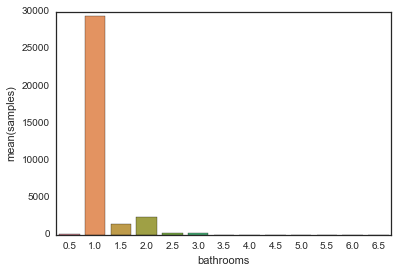

In [144]:
sns.barplot(x="bathrooms", y="samples", data=dfs[0])
print dfs[0].info()
dfs[0]

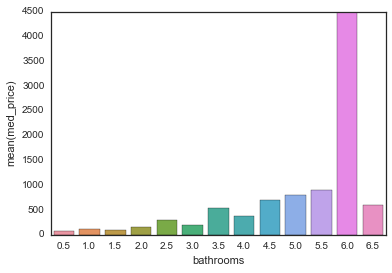

In [145]:
# bar chart of prices
# histogram of listings

sns.barplot(x="bathrooms", y="med_price", data=dfs[0])

### this demonstrates the value of exploratory data analysis and data visualization... number of bathrooms might seem like it would be a good indicator, but we have very few samples other than 1.0, 1.5, 2.0

,beds,samples,med_price
0,1,23245,99.0
1,2,7367,150.0
2,3,2286,195.0
3,4,845,220.0
4,5,296,275.0
5,6,184,299.5
6,7,44,234.0
7,8,33,300.0
8,9,15,399.0
9,10,13,400.0


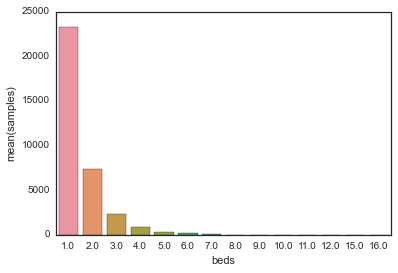

In [146]:
sns.barplot(x="beds", y="samples", data=dfs[1])
dfs[1]

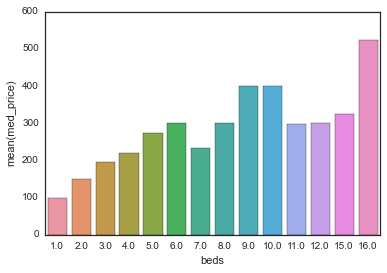

In [147]:
sns.barplot(x="beds", y="med_price", data=dfs[1])

,bedrooms,samples,med_price
0,1,25843,99.0
1,2,4182,200.0
2,3,1051,280.0
3,4,236,399.5
4,5,58,399.0
5,6,20,630.0
6,7,6,925.0
7,8,2,1000.0
8,9,1,130.0
9,10,3,800.0


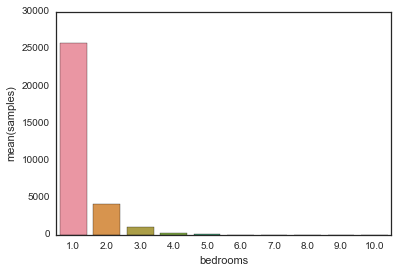

In [148]:
sns.barplot(x="bedrooms", y="samples", data=dfs[2])
dfs[2]

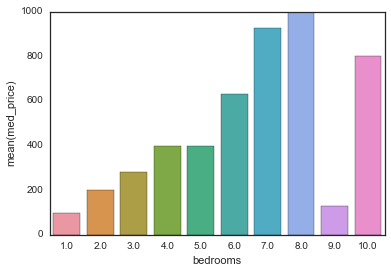

In [149]:
sns.barplot(x="bedrooms", y="med_price", data=dfs[2])

### 9 bedrooms for \$130 seems like an outlier...
* #### Sidebar: displaying a webpage

In [150]:
from selenium import webdriver

q = "SELECT lid FROM listings WHERE bedrooms = 9.0"
url = 'https://www.airbnb.com/rooms/{0}'.format(query(q).values[0,0])

print url
driver = webdriver.Chrome(executable_path='/opt/chromedriver')
driver.get(url)

https://www.airbnb.com/rooms/287417


In [151]:
import requests
from IPython.core.display import HTML
# HTML(requests.get(url).text)

### Reusable code:
* #### This is something we might want to re-use so we can make a function to bring up a url:

In [152]:
def listing_url(q, open_where):
    url = 'https://www.airbnb.com/rooms/{0}'.format(query(q).values[0,0])
    if open_where == 'chrome':
        driver = webdriver.Chrome(executable_path='/opt/chromedriver')
        driver.get(url)
    elif open_where == 'notebook':
        HTML(requests.get(url).text)
    elif open_where == 'url':
        return url
    else:
        print "choose 'chrome', 'notebook', or 'url' as second parameter"

### In the listing: Extra people: \$35 / night after 2 guests ... we'll return to this later

In [153]:
q = """
SELECT price, price_for_extra_person_native, guests_included, person_capacity
FROM listings
WHERE lid = 
  (SELECT lid FROM listings WHERE bedrooms = 9.0)
"""
query(q)

,price,price_for_extra_person_native,guests_included,person_capacity
0,130,35,2,16


#### Same plots on guests_included and person_capacity

In [154]:
dfs = []
for c in ['guests_included', 'person_capacity']:
    q = """
    SELECT {0}, count(*) as samples
    FROM listings
    GROUP BY 1
    ORDER BY 1
    """.format(c)
    dfs.append(query(q).dropna())

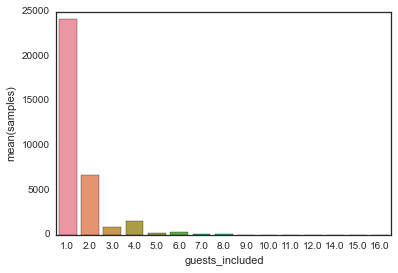

In [155]:
sns.barplot(x="guests_included", y="samples", data=dfs[0])

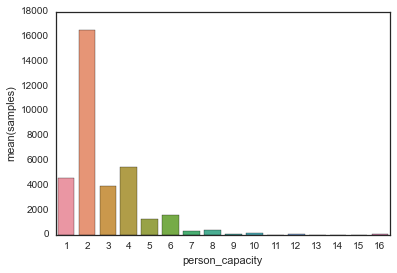

In [156]:
sns.barplot(x="person_capacity", y="samples", data=dfs[1])

#### More plots

In [157]:
q = """
SELECT price, bathrooms
FROM listings
WHERE bathrooms < 5.0
ORDER BY 2
"""
df = query(q).dropna()

[(0, 500)]

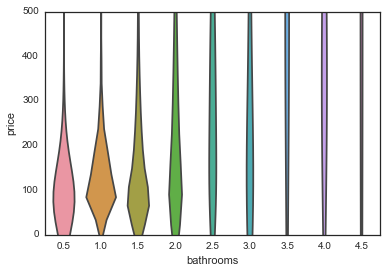

In [158]:
ax = sns.violinplot(x="bathrooms", y="price", data=df, inner=None)
ax.set(ylim=(0,500))

In [159]:
q = """
SELECT price, bedrooms
FROM listings
WHERE bedrooms < 6.5
ORDER BY 2
"""
df = query(q).dropna()

[(0, 500)]

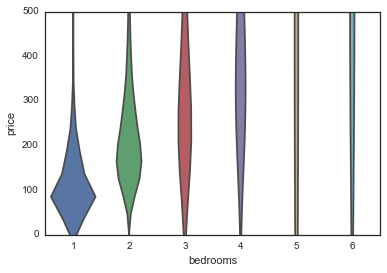

In [160]:
ax = sns.violinplot(x="bedrooms", y="price", data=df, inner=None)
ax.set(ylim=(0,500))

## Break?

### SQL sidebar during break: 
* #### normalizing data (z-scores)
 * #### some models require it
 * #### can help with visualization (everything on the same scale)
* #### subqueries in FROM clause:
```
SELECT <something>
FROM <table>, (SELECT statement) <name>
```

In [161]:
q = """
SELECT (price - stats.ave)/stats.std::float as price_z, 
        (guests_included - ave_g)/std_g::float as guests_z
FROM listings, 
      (SELECT avg(price) as ave, 
          stddev(price) as std, 
          avg(guests_included) as ave_g, 
         stddev(guests_included) as std_g
       FROM listings) stats"""
df = query(q)
df.head()

,price_z,guests_z
0,-0.247518,0.511497
1,-0.467637,-0.468223
2,-0.467637,-0.468223
3,-0.027399,0.511497
4,-0.593420,0.511497


## Module 8: visualizing categorical variables

In [163]:
q = """
SELECT neighborhood, median(price) AS price
FROM listings
GROUP BY 1
ORDER BY 2 DESC"""

df = query(q)
df.head()

,neighborhood,price
0,Tribeca,250.0
1,Midtown,223.5
2,Union Square,210.0
3,Noho,209.0
4,Times Square/Theatre District,205.0


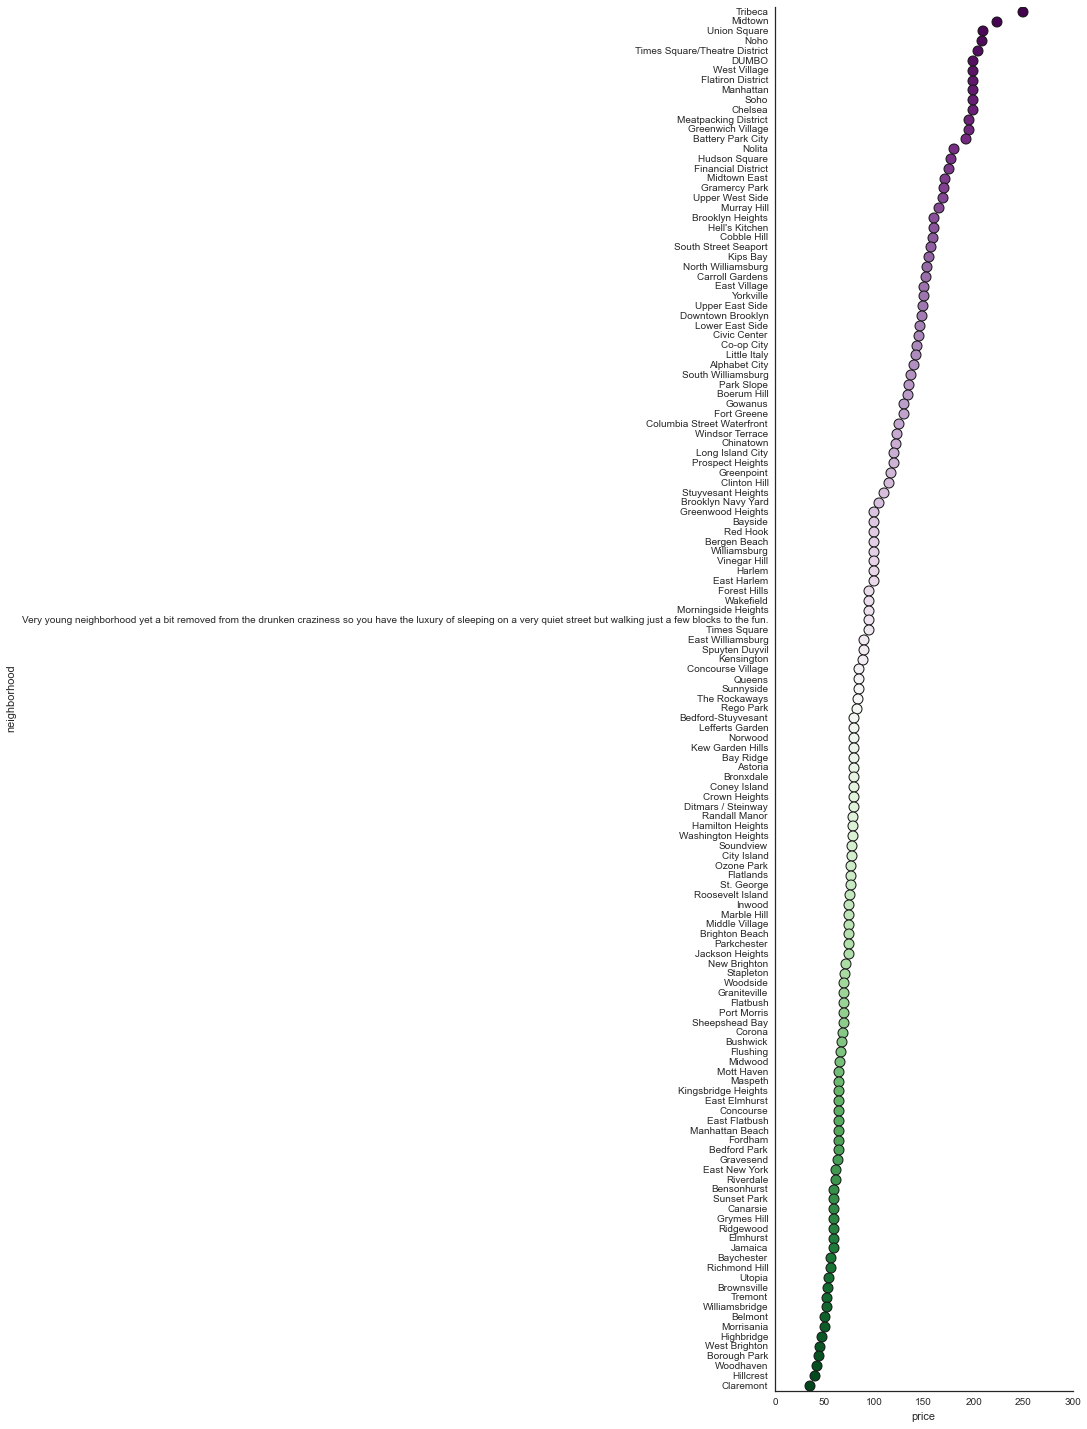

In [164]:
g = sns.PairGrid(df.sort_values(by='price', ascending=False),
                 x_vars=['price'], y_vars=["neighborhood"],
                 size=20, aspect=.25)

g.map(sns.stripplot, size=10, orient="h",
      palette="PRGn", edgecolor="gray")

### What happened?! 

In [165]:
q = """
SELECT * 
FROM listings
WHERE neighborhood LIKE 'Very%'"""

listing_url(q, 'chrome')

In [166]:
import json
api = 'https://api.airbnb.com/v2/listings/{0}?client_id=3092nxybyb0otqw18e8nh5nty&_format=v1_legacy_for_p3'\
        .format(query(q).lid.values[0])
listing_data = json.loads(requests.get(api).text)
listing_data

{u'listing': {u'access': u'You have access to the shared kitchen, bathroom, and living room in addition to a private bedroom with private HDTV.',
  u'address': u'New York, NY, United States',
  u'amenities': [u'TV',
   u'Cable TV',
   u'Internet',
   u'Wireless Internet',
   u'Air Conditioning',
   u'Kitchen',
   u'Heating',
   u'Smoke Detector',
   u'Carbon Monoxide Detector',
   u'First Aid Kit',
   u'Essentials',
   u'Shampoo'],
  u'amenities_ids': [1, 2, 3, 4, 5, 8, 30, 35, 36, 37, 40, 41],
  u'bathrooms': 1.0,
  u'bed_type': u'Real Bed',
  u'bed_type_category': u'real_bed',
  u'bedrooms': 1,
  u'beds': 1,
  u'calendar_updated_at': u'2 months ago',
  u'cancel_policy': 3,
  u'cancel_policy_short_str': u'Flexible',
  u'cancellation_policy': u'flexible',
  u'check_in_time': 12,
  u'check_out_time': 16,
  u'city': u'New York',
  u'cleaning_fee_native': None,
  u'collection_ids': None,
  u'country': u'United States',
  u'country_code': u'US',
  u'currency_symbol_left': u'$',
  u'currenc

In [167]:
listing_data['listing']['neighborhood']

u'Very young neighborhood yet a bit removed from the drunken craziness so you have the luxury of sleeping on a very quiet street but walking just a few blocks to the fun.'

### Omit the erroneous value

In [168]:
q = """
SELECT neighborhood, median(price) AS price
FROM listings
WHERE neighborhood NOT LIKE 'Very%'
GROUP BY 1
ORDER BY 2 DESC"""
df = query(q)

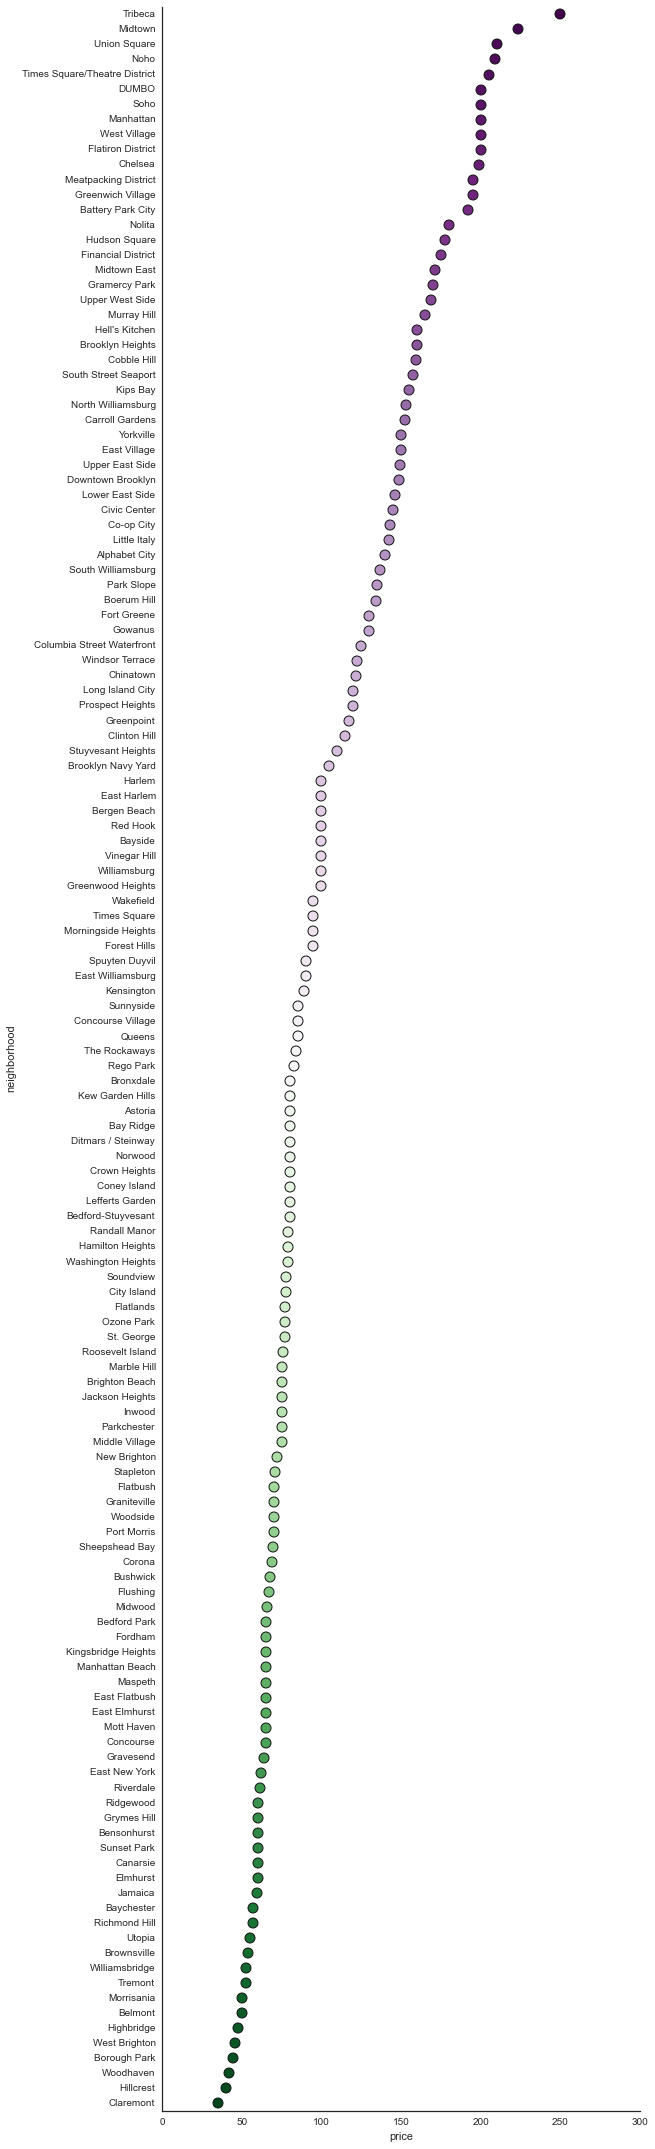

In [169]:
# Make the PairGrid
g = sns.PairGrid(df.sort_values(by='price', ascending=False),
                 x_vars=['price'], y_vars=["neighborhood"],
                 size=30, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="PRGn", edgecolor="gray")

## Module 9: Postgres Arrays

* #### The amenities field was filled with text

In [170]:
q = """
SELECT amenities
FROM listings
LIMIT 5"""
query(q)

,amenities
0,"Internet,Wireless Internet,Air Conditioning,Ki..."
1,"Internet,Wireless Internet,Air Conditioning,Ki..."
2,"TV,Internet,Wireless Internet,Air Conditioning..."
3,"TV,Cable TV,Internet,Wireless Internet,Air Con..."
4,"TV,Internet,Wireless Internet,Air Conditioning..."


### Postgres has native arrays that work as expected and have built-in methods
* #### string_to_array method

In [171]:
q = """
SELECT string_to_array(amenities,',')
FROM listings
LIMIT 5"""
query(q)

,string_to_array
0,"[Internet, Wireless Internet, Air Conditioning..."
1,"[Internet, Wireless Internet, Air Conditioning..."
2,"[TV, Internet, Wireless Internet, Air Conditio..."
3,"[TV, Cable TV, Internet, Wireless Internet, Ai..."
4,"[TV, Internet, Wireless Internet, Air Conditio..."


In [172]:
q = """
SELECT DISTINCT(unnest(string_to_array(amenities,','))) AS amenities
FROM listings
"""
amenities = query(q)
all_amenities = sorted(list(amenities.amenities.values))
print all_amenities

['24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector', 'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed', 'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer', 'Wheelchair Accessible', 'Wireless Internet']


## Break?

## Module 10: PL/Python
* ### in order to use the amenities field, we might want a table of binary values indicating whether that listing has that corresponding amenity
* ### this is a pain in pure SQL (41 case statements?)
* ### first, let's think about it in pure python:
 * we have a list of all possible amenities
 * we have a list of amenities for each listing

In [173]:
q = """
SELECT lid, string_to_array(amenities,',')
FROM listings
LIMIT 1"""
listing_amenities = query(q)
listing_amenities = list(listing_amenities.string_to_array.values[0])
listing_amenities

['Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Smoke Detector',
 'Carbon Monoxide Detector',
 'Essentials']

### Loops vs. list comprehension

In [174]:
%%timeit
vec = []
for a in all_amenities:
    vec.append(int(a in listing_amenities))

100000 loops, best of 3: 11.6 µs per loop


In [175]:
%%timeit
vec = [int(a in listing_amenities) for a in all_amenities]

100000 loops, best of 3: 9.71 µs per loop


In [176]:
vec = [a for a in all_amenities]
print vec

['24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector', 'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed', 'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer', 'Wheelchair Accessible', 'Wireless Internet']


### PL/Python Syntax
```sql
CREATE OR REPLACE FUNCTION <name>(<parameter> <datatype>)
    RETURNS <return type>
AS
$$  
	<python code>
$$ 
LANGUAGE PLPYTHONU;```

### Return types
* #### return an array:

In [177]:
q = """
CREATE OR REPLACE FUNCTION dev.amenities_arr(listing_amenities text[])
    RETURNS int[]
AS
$$  
    all_amenities = list({0})
    
    return [int(a in listing_amenities) for a in all_amenities]
$$ 
LANGUAGE PLPYTHONU;""".format(all_amenities)
print q
query(q, False)


CREATE OR REPLACE FUNCTION dev.amenities_arr(listing_amenities text[])
    RETURNS int[]
AS
$$  
    all_amenities = list(['24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector', 'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed', 'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer', 'Wheelchair Accessible', 'Wireless Internet'])
    
    return [int(a in listing_amenities) for a in all_amenities]
$$ 
LANGUAGE PLPYTHONU;


In [178]:
q = """
SELECT lid, dev.amenities_arr(string_to_array(amenities,','))
FROM listings
LIMIT 1"""
query(q)

,lid,amenities_arr
0,6029332,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### that's great, but how do we know which index corresponds to which? 
* #### this is where custom types come in

In [179]:
q = 'CREATE TYPE amenities_type AS (\n' + \
'\n'.join([', ' + a.replace(' ','_')
                   .replace('-','_')
                   .replace('/','_')
                   .replace('24','x24')
                   .replace('(','')
                   .replace(')','') \
                + ' SMALLINT' for a in all_amenities])[2:] + \
')'
print q[:100]
print '...'
print q[-100:]
query(q, False)

CREATE TYPE amenities_type AS (
x24_Hour_Check_in SMALLINT
, Air_Conditioning SMALLINT
, Breakfast S
...
er SMALLINT
, Washer___Dryer SMALLINT
, Wheelchair_Accessible SMALLINT
, Wireless_Internet SMALLINT)


#### same as previous PL/Python function, except with a custom return type

In [180]:
q = """
CREATE OR REPLACE FUNCTION dev.amenities_vec(listing_amenities text[])
    RETURNS amenities_type
AS
$$  
    all_amenities = list({0})
    
    return [int(a in listing_amenities) for a in all_amenities]
$$ 
LANGUAGE PLPYTHONU;""".format(all_amenities)
query(q, False)

In [181]:
q = """
SELECT lid, dev.amenities_vec(string_to_array(amenities,','))
FROM listings
LIMIT 1"""
query(q)

,lid,amenities_vec
0,6029332,"(0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1..."


#### The magic...

In [182]:
q = """
SELECT lid, (dev.amenities_vec(string_to_array(amenities,','))).*
FROM listings
LIMIT 1"""
query(q)

,lid,x24_hour_check_in,air_conditioning,breakfast,buzzer_wireless_intercom,cable_tv,carbon_monoxide_detector,cats,dogs,doorman,...,safety_card,shampoo,smoke_detector,smoking_allowed,suitable_for_events,tv,washer,washer___dryer,wheelchair_accessible,wireless_internet
0,6029332,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Summary of what we just did
* #### turned a text field into an array
* #### dynamically created a custom type containing all amenities: nothing is hard-coded!
* #### we didn't have to copy-paste 41 names or create 41 case statements!
* #### we were able to expand into a row with 41 columns
* #### we can now make a table containing the presence of all amenities by listing, and compute 

## Views vs. Internal Tables

#### upfront time vs. query time

### Views

* #### View via internal table

In [183]:
%%time
q = """
CREATE OR REPLACE VIEW dev.x00010_amenities_view AS
SELECT lid, (dev.amenities_vec(string_to_array(amenities,','))).*
FROM listings
WHERE amenities <> ''
"""
query(q, False)

CPU times: user 263 µs, sys: 412 µs, total: 675 µs
Wall time: 68.6 ms


In [184]:
%%time
q = """
SELECT *
FROM dev.x00010_amenities_view
"""
query(q)

CPU times: user 406 ms, sys: 119 ms, total: 524 ms
Wall time: 3min 33s


* #### View via external table

In [212]:
%%time
q = """
CREATE OR REPLACE VIEW dev.x00010_amenities_view_ext AS
SELECT lid, (dev.amenities_vec(string_to_array(amenities,','))).*
FROM ext_listings
WHERE amenities <> ''
"""
query(q, False)

CPU times: user 276 µs, sys: 639 µs, total: 915 µs
Wall time: 34.1 ms


In [213]:
%%time
q = """
SELECT *
FROM dev.x00010_amenities_view_ext
"""
query(q)

CPU times: user 391 ms, sys: 77.2 ms, total: 468 ms
Wall time: 3min 24s


### Internal Tables

In [185]:
%%time
q = """
CREATE TABLE dev.x00010_amenities_table AS
SELECT lid, (dev.amenities_vec(string_to_array(amenities,','))).*
FROM listings
WHERE amenities <> ''
DISTRIBUTED RANDOMLY
"""
query(q, False)

CPU times: user 13.7 ms, sys: 9.82 ms, total: 23.6 ms
Wall time: 4min 12s


In [186]:
%%time
q = """
SELECT *
FROM dev.x00010_amenities_table
"""
query(q)

CPU times: user 363 ms, sys: 85.6 ms, total: 448 ms
Wall time: 2.22 s


## Break and brainstorm: analyze the amenities table

### How can we create queries for the following:
* #### what amenities are most common?
* #### how can we look at which might be the most informative for price?
* #### how might we visualize this?

In [187]:
q = """
SELECT price, a.doorman
FROM dev.x00010_amenities_table a, listings l
WHERE a.lid = l.lid
"""
df = query(q)
df.head()

,price,doorman
0,110,0
1,75,0
2,75,0
3,145,0
4,55,0


In [188]:
q = ["""
SELECT sum(doorman)::float/count(doorman)::float AS prop
FROM (SELECT price, a.*
      FROM dev.x00010_amenities_table a, listings l
      WHERE a.lid = l.lid) q
""","""
SELECT doorman, avg(price)
FROM (SELECT price, a.*
      FROM dev.x00010_amenities_table a, listings l
      WHERE a.lid = l.lid) q
GROUP BY doorman
"""]

In [189]:
query(q[0])

,prop
0,0.11433


In [190]:
query(q[1])

,doorman,avg
0,0,139.80724980825
1,1,218.468096099199


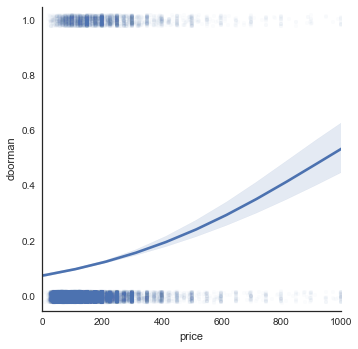

In [191]:
g = sns.lmplot(x="price", y="doorman", data=df,
               palette="6495ED", y_jitter=.02, logistic=True, 
               scatter_kws = {'alpha':0.02})
g.set(xlim=(0, 1000), ylim=(-.05, 1.05))

### Assessing where we are

* #### we have an idea of what features may be useful
 * in practice, we'd want to keep exploring some more


* #### we have an idea of a dependent variable: price


## Module 11: forming our training/test sets

* #### earlier, we noticed an issue with prices -- number of bedrooms
 * we can cap the bedrooms/beds as number of guests included
 * feature engineering

In [192]:
q = """
SELECT beds, guests_included, 
       CASE WHEN guests_included <= bedrooms THEN guests_included
         ELSE bedrooms END AS bedrooms_adj,
       CASE WHEN guests_included <= beds THEN guests_included
         ELSE beds END AS beds_adj
FROM listings
ORDER BY beds DESC
"""
query(q).dropna().head()

,beds,guests_included,bedrooms_adj,beds_adj
86,16,16,7,16
87,16,1,1,1
88,16,1,1,1
89,16,2,2,2
90,16,16,8,16


#### back to our list of columns to keep

In [193]:
print keepers

['room_type_category', 'bed_type_category', 'cancellation_policy', 'star_rating', 'bedrooms', 'bathrooms', 'beds', 'guests_included', 'person_capacity', 'property_type', 'min_nights_input_value', 'listing_price_for_extra_person_native', 'picture_count', 'neighborhood', 'listing_cleaning_fee_native', 'extras_price_native', 'listing_security_deposit_native', 'security_deposit_native', 'max_nights_input_value', 'reviews_count', 'listing_weekend_price_native', 'price', 'weekly_price_native']


### String manipulation is important, so let's whiteboard how to select
* #### only these columns
* #### excluding bedrooms, beds
* #### plus bedrooms_adj, beds_adj

#### starter:
```sql
SELECT CASE WHEN guests_included <= bedrooms THEN guests_included
            ELSE bedrooms END AS bedrooms_adj,
       CASE WHEN guests_included <= beds THEN guests_included
            ELSE beds END AS beds_adj
       , lid
```

In [194]:
q = """SELECT CASE WHEN guests_included <= bedrooms THEN guests_included
    ELSE bedrooms END AS bedrooms_adj,
  CASE WHEN guests_included <= beds THEN guests_included
    ELSE beds END AS beds_adj
  , lid \n"""

q += '\n'.join([', {0}'.format(k) for k in keepers if k not in ['bedrooms', 'beds']])
q += '\n FROM listings'
query(q).head()

,bedrooms_adj,beds_adj,lid,room_type_category,bed_type_category,cancellation_policy,star_rating,bathrooms,guests_included,person_capacity,...,neighborhood,listing_cleaning_fee_native,extras_price_native,listing_security_deposit_native,security_deposit_native,max_nights_input_value,reviews_count,listing_weekend_price_native,price,weekly_price_native
0,1,2,6029332,private_room,real_bed,flexible,5,1.5,2,3,...,Williamsburg,NaN,NaN,NaN,NaN,NaN,4,115,110,684
1,1,1,4325397,private_room,real_bed,moderate,NaN,1.0,1,2,...,Astoria,50,50,350,350,NaN,1,90,75,525
2,1,1,6422551,private_room,real_bed,flexible,NaN,1.0,1,2,...,Williamsburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,550
3,1,1,6684697,private_room,real_bed,moderate,5,1.0,2,3,...,Williamsburg,30,30,750,750,NaN,7,NaN,145,NaN
4,1,2,4587554,private_room,real_bed,moderate,5,1.0,2,2,...,Maspeth,NaN,NaN,NaN,NaN,20,21,NaN,55,350


### Remember how to create table?

#### hint: the syntax is referred to as CTAS

In [195]:
q2 = 'CREATE TABLE dev.x00010_listings_modified_all AS \n ' + q

#### we found that problematic neighborhood

In [196]:
q2 += "\n WHERE neighborhood NOT LIKE 'Very%' \n DISTRIBUTED RANDOMLY"

In [197]:
query('DROP TABLE IF EXISTS dev.x00010_listings_modified_all')
query(q2, False)

## 80/20 Train/Test split
* #### Simplest approach: append a random number Unif(0,1), and put >0.80 in test

In [198]:
q = """
CREATE TEMPORARY TABLE training_split AS
SELECT lid, random() AS random
FROM dev.x00010_listings_modified_all"""
query(q, False)

In [199]:
q = """
SELECT lid, random, 
  CASE WHEN random > 0.8 THEN 'test'
  ELSE 'train' END AS set_type
FROM training_split
"""
query(q).head()

,lid,random,set_type
0,6029332,0.745662,train
1,4325397,0.130880,train
2,6422551,0.045285,train
3,6684697,0.771927,train
4,4587554,0.274045,train


In [200]:
q = """
SELECT count(*)::float/(SELECT COUNT(*) FROM training_split)::float AS split,  
  CASE WHEN random > 0.8 THEN 'test'
  ELSE 'train' END AS set_type
FROM training_split
GROUP BY 2
"""
query(q)

,split,set_type
0,0.197203,test
1,0.802797,train


## Break

### Randomized block sampling in HAWQ for those interested
* #### whiteboard for motivation
* #### what if the training set has higher or lower average price?
* #### what if some of the independent variables are skewed
* #### why (in general) shouldn't we do this in PL/Python?
* #### note: this is ugly code, but I have re-used it many times

```sql
select setseed(0.444);

WITH randomID AS (
    -- First assign a random ID to all rows. This will give us a random order.
SELECT lid, beds_adj, bedrooms_adj, neighborhood,
  CASE WHEN price < summary.first_quartile THEN 1 
    WHEN price < summary.median THEN 2 
    WHEN price < summary.third_quartile THEN 3
    ELSE 4 END AS price_quartile
    , random() as random 
  FROM dev.x00010_listings_modified_all listings, dev.x00000_listings_summary summary
  GROUP BY 1, 2, 3, 4, 5),
countGroups AS (
  -- Now we add row numbers for each group. So each group will start at 1. We order 
  -- by the random column we generated in the previous expression, so you should get
  -- different results in each execution
  SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY beds_adj, bedrooms_adj, neighborhood, price_quartile ORDER BY random) AS     rowcnt FROM randomID
)
-- Use the rowcnt as a propoertion of size of the block
SELECT *, rowcnt::float/(SELECT MAX(rowcnt) 
           FROM countGroups c2 
           WHERE c1.beds_adj = c2.beds_adj 
            AND c1.bedrooms_adj = c2.bedrooms_adj 
            AND c1.neighborhood = c2.neighborhood
            AND c1.price_quartile = c2.price_quartile
           )::float as prop
    FROM countGroups c1
```

In [201]:
q = """SELECT lid, beds_adj, bedrooms_adj, neighborhood,
CASE WHEN price < summary.first_quartile THEN 1 
 WHEN price < summary.median THEN 2 
 WHEN price < summary.third_quartile THEN 3
 ELSE 4 END AS price_quartile
, random() as random 
FROM dev.x00010_listings_modified_all listings, dev.x00000_listings_summary summary"""
query(q).head()

,lid,beds_adj,bedrooms_adj,neighborhood,price_quartile,random
0,6029332,2,1,Williamsburg,2,0.512322
1,4325397,1,1,Astoria,2,0.729473
2,6422551,1,1,Williamsburg,2,0.797854
3,6684697,1,1,Williamsburg,3,0.920444
4,4587554,2,1,Maspeth,1,0.503167


In [202]:
q = """
WITH randomID AS (
    -- First assign a random ID to all rows. This will give us a random order.
SELECT lid, beds_adj, bedrooms_adj, neighborhood,
  CASE WHEN price < summary.first_quartile THEN 1 
    WHEN price < summary.median THEN 2 
    WHEN price < summary.third_quartile THEN 3
    ELSE 4 END AS price_quartile
    , random() as random 
  FROM dev.x00010_listings_modified_all listings, dev.x00000_listings_summary summary
  GROUP BY 1, 2, 3, 4, 5),
countGroups AS (
  -- Now we add row numbers for each group. So each group will start at 1. We order 
  -- by the random column we generated in the previous expression, so you should get
  -- different results in each execution
  SELECT *, ROW_NUMBER() OVER (PARTITION BY beds_adj, bedrooms_adj, neighborhood, price_quartile ORDER BY random) AS     rowcnt FROM randomID
)
SELECT * from countGroups"""
query(q).head()

,lid,beds_adj,bedrooms_adj,neighborhood,price_quartile,random,rowcnt
0,6589851,1,1,Alphabet City,1,0.006135,1
1,9115146,1,1,Alphabet City,1,0.013195,2
2,2207684,1,1,Alphabet City,1,0.014403,3
3,8522756,1,1,Alphabet City,1,0.058219,4
4,4621510,1,1,Alphabet City,1,0.061482,5


In [203]:
q = """
WITH randomID AS (
    -- First assign a random ID to all rows. This will give us a random order.
SELECT lid, beds_adj, bedrooms_adj, neighborhood,
  CASE WHEN price < summary.first_quartile THEN 1 
    WHEN price < summary.median THEN 2 
    WHEN price < summary.third_quartile THEN 3
    ELSE 4 END AS price_quartile
    , random() as random 
  FROM dev.x00010_listings_modified_all listings, dev.x00000_listings_summary summary
  GROUP BY 1, 2, 3, 4, 5),
countGroups AS (
  -- Now we add row numbers for each group. So each group will start at 1. We order 
  -- by the random column we generated in the previous expression, so you should get
  -- different results in each execution
  SELECT *, 
    ROW_NUMBER() OVER (PARTITION BY beds_adj, bedrooms_adj, neighborhood, price_quartile ORDER BY random) AS     rowcnt FROM randomID
)
-- Now we get the data
SELECT lid, beds_adj, bedrooms_adj, neighborhood, price_quartile, rowcnt::float/(SELECT MAX(rowcnt) 
           FROM countGroups c2 
           WHERE c1.beds_adj = c2.beds_adj 
            AND c1.bedrooms_adj = c2.bedrooms_adj 
            AND c1.neighborhood = c2.neighborhood
            AND c1.price_quartile = c2.price_quartile
           )::float as prop
    FROM countGroups c1
"""
query(q).head()

,lid,beds_adj,bedrooms_adj,neighborhood,price_quartile,prop
0,5875665,1,1,Alphabet City,1,0.016949
1,9820483,1,1,Alphabet City,1,0.033898
2,9505654,1,1,Alphabet City,1,0.050847
3,7065748,1,1,Alphabet City,1,0.067797
4,8889664,1,1,Alphabet City,1,0.084746


In [204]:
query('CREATE OR REPLACE VIEW dev.x00011_stratified AS ({0})'.format(q), False)

### Now we can do any sort of split:
* #### test/train split
* #### test/train/cross-validation split
* #### k-fold cross-validation

#### Choose 60/20/20 Train/CV/Test

In [205]:
query("""
CREATE OR REPLACE VIEW dev.x00012_set_type AS 
SELECT *,
 CASE WHEN prop < 0.2 THEN 'test'
  WHEN prop < 0.4 THEN 'cv'
  ELSE 'train' END AS set_type
FROM dev.x00011_stratified
""", False)

### Test the split

In [206]:
query("""
SELECT d.beds_adj, d.bedrooms_adj, d.neighborhood, d.price_quartile, d.set_type, 
       count(*)::float/counts.tot::float as prop 
FROM dev.x00012_set_type d,
  (SELECT beds_adj, bedrooms_adj, neighborhood, price_quartile, count(*) as tot
    FROM dev.x00012_set_type
    GROUP BY 1, 2, 3, 4) counts
WHERE counts.beds_adj=d.beds_adj
   AND counts.bedrooms_adj=d.bedrooms_adj
   AND counts.neighborhood=d.neighborhood
   AND counts.price_quartile=d.price_quartile
GROUP BY 1, 2, 3, 4, 5, counts.tot
ORDER BY 1, 2, 3, 4, 5
""").head(25)

,beds_adj,bedrooms_adj,neighborhood,price_quartile,set_type,prop
0,1,1,Alphabet City,1,cv,0.203390
1,1,1,Alphabet City,1,test,0.186441
2,1,1,Alphabet City,1,train,0.610169
3,1,1,Alphabet City,2,cv,0.201923
4,1,1,Alphabet City,2,test,0.197115
5,1,1,Alphabet City,2,train,0.600962
6,1,1,Alphabet City,3,cv,0.198953
7,1,1,Alphabet City,3,test,0.198953
8,1,1,Alphabet City,3,train,0.602094
9,1,1,Alphabet City,4,cv,0.197279


### It's a good time to clean up the dataset (using manual inspection)

In [216]:
### prepare this to be a dummy variable
q = """
CREATE OR REPLACE FUNCTION clean_categorical(n text)
    RETURNS text
AS
$$  
    if not n:
      return 'NA'
    return n.replace(' ','_')\
            .replace('-','_')\
            .replace('/','_')\
            .replace("'",'')\
            .replace('(','')\
            .replace(')','')\
            .replace('.','')\
            .replace('&','')\
            .lower()
$$ 
LANGUAGE PLPYTHONU;
"""
query(q, False)

In [218]:
q="""
CREATE OR REPLACE VIEW dev.x00013_listings_all_cleaned AS
SELECT lid, bedrooms_adj, beds_adj, room_type_category, 
   bed_type_category, bathrooms, guests_included, 
   clean_categorical(property_type) as property_type
   , CASE WHEN min_nights_input_value IS NULL THEN 0 ELSE min_nights_input_value END AS min_nights
   , CASE WHEN picture_count IS NULL THEN 0 ELSE picture_count END AS picture_count
   , CASE WHEN reviews_count IS NULL THEN 0 ELSE reviews_count END AS reviews_count
   , clean_categorical(neighborhood) as neighborhood
   , CASE WHEN extras_price_native IS NULL THEN 0 
       ELSE extras_price_native END AS extras
   , CASE WHEN listing_weekend_price_native IS NULL THEN price
       ELSE listing_weekend_price_native END as price
FROM  dev.x00010_listings_modified_all
"""
query(q, False)

## Module 12: categorical variables
* #### we'll need to create dummy variables
* #### http://doc.madlib.net/master/group__grp__data__prep.html
* #### quickly gloss over the next few slides

In [219]:
df = query('SELECT * FROM dev.x00013_listings_all_cleaned LIMIT 2')
df

,lid,bedrooms_adj,beds_adj,room_type_category,bed_type_category,bathrooms,guests_included,property_type,min_nights,picture_count,reviews_count,neighborhood,extras,price
0,6029332,1,2,private_room,real_bed,1.5,2,apartment,2,15,4,williamsburg,0,115
1,4325397,1,1,private_room,real_bed,1.0,1,apartment,2,3,1,astoria,50,90


In [220]:
query('DROP TABLE IF EXISTS dev.x00014_categorical_cleaned CASCADE')
categorical = ['room_type_category', 'bed_type_category', 'property_type', 'neighborhood']
q = 'CREATE TABLE dev.x00014_categorical_cleaned AS \n SELECT lid \n' 
q += '\n'.join([', {0}'.format(c) for c in categorical])
q += '\n FROM dev.x00013_listings_all_cleaned DISTRIBUTED RANDOMLY'
query(q, False)

In [221]:
non_categorical = [c for c in df.columns if c not in categorical]
q = 'CREATE OR REPLACE VIEW dev.x00015_non_categorical_cleaned AS \n SELECT lid \n' 
q += '\n'.join([', {0}'.format(c) for c in non_categorical])[2:]
q += '\n FROM dev.x00013_listings_all_cleaned'
query(q, False)

### Keeping stock:
* #### dev.x00010_amenities_table has the amenities columns
* #### dev.x00012_set_type has the set type (train, cv, test)
* #### dev.x00014_categorical_cleaned has the categorical values
* #### dev.x00015_non_categorical_cleaned has the non-categorical values
* #### all can be joined on lid

### Use MADlib to create dummy variables

In [222]:
q =["""DROP TABLE IF EXISTS dev.tmp1""",
    
"""
SELECT madlib.create_indicator_variables 
      ('dev.x00014_categorical_cleaned', 
      'dev.tmp1', 
      'bed_type_category')""",
"""
SELECT * 
FROM dev.tmp1
LIMIT 5
"""]
query(q)

,lid,room_type_category,bed_type_category,property_type,neighborhood,bed_type_category_airbed,bed_type_category_couch,bed_type_category_futon,bed_type_category_pull_out_sofa,bed_type_category_real_bed
0,6029332,private_room,real_bed,apartment,williamsburg,0,0,0,0,1
1,4325397,private_room,real_bed,apartment,astoria,0,0,0,0,1
2,6422551,private_room,real_bed,apartment,williamsburg,0,0,0,0,1
3,6684697,private_room,real_bed,apartment,williamsburg,0,0,0,0,1
4,4587554,private_room,real_bed,house,maspeth,0,0,0,0,1


### We can use simple string manipulations keep creating new tables based on the previous table

In [223]:
old_table = 'dev.x00014_categorical_cleaned'
for i, c in enumerate(categorical):
    new_table = 'dev.tmp{0}'.format(i)
    q = """
    SELECT madlib.create_indicator_variables 
          ('{0}', 
          '{1}', 
          '{2}')""".format(old_table, new_table, c)
    old_table = new_table
    print q


    SELECT madlib.create_indicator_variables 
          ('dev.x00014_categorical_cleaned', 
          'dev.tmp0', 
          'room_type_category')

    SELECT madlib.create_indicator_variables 
          ('dev.tmp0', 
          'dev.tmp1', 
          'bed_type_category')

    SELECT madlib.create_indicator_variables 
          ('dev.tmp1', 
          'dev.tmp2', 
          'property_type')

    SELECT madlib.create_indicator_variables 
          ('dev.tmp2', 
          'dev.tmp3', 
          'neighborhood')


In [224]:
old_table = 'dev.x00014_categorical_cleaned'
for i, c in enumerate(categorical):
    new_table = 'dev.tmp{0}'.format(i)
    query('DROP TABLE IF EXISTS {0} CASCADE'.format(new_table))    
    q = """
    SELECT madlib.create_indicator_variables 
          ('{0}', 
          '{1}', 
          '{2}')""".format(old_table, new_table, c)
    old_table = new_table
    query(q)

In [225]:
df = query('SELECT * FROM dev.tmp3 LIMIT 5')
df.head()

,lid,room_type_category,bed_type_category,property_type,neighborhood,room_type_category_entire_home,room_type_category_private_room,room_type_category_shared_room,bed_type_category_airbed,bed_type_category_couch,...,neighborhood_wakefield,neighborhood_washington_heights,neighborhood_west_brighton,neighborhood_west_village,neighborhood_williamsbridge,neighborhood_williamsburg,neighborhood_windsor_terrace,neighborhood_woodhaven,neighborhood_woodside,neighborhood_yorkville
0,6029332,private_room,real_bed,apartment,williamsburg,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4325397,private_room,real_bed,apartment,astoria,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6422551,private_room,real_bed,apartment,williamsburg,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,6684697,private_room,real_bed,apartment,williamsburg,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4587554,private_room,real_bed,house,maspeth,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [226]:
q = 'SELECT '
q += '\n'.join([', {0} '.format(c) for c in df.columns if c not in categorical and c.lower() != 'property_type_na'])[2:]
q += 'FROM dev.tmp3 LIMIT 5'
query(q)

,lid,room_type_category_entire_home,room_type_category_private_room,room_type_category_shared_room,bed_type_category_airbed,bed_type_category_couch,bed_type_category_futon,bed_type_category_pull_out_sofa,bed_type_category_real_bed,property_type_apartment,...,neighborhood_wakefield,neighborhood_washington_heights,neighborhood_west_brighton,neighborhood_west_village,neighborhood_williamsbridge,neighborhood_williamsburg,neighborhood_windsor_terrace,neighborhood_woodhaven,neighborhood_woodside,neighborhood_yorkville
0,6029332,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,4325397,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6422551,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,6684697,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,4587554,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
q = 'CREATE TABLE dev.x00016_categorical_dummy AS SELECT '
q += '\n'.join([', {0} '.format(c) for c in df.columns \
                if c not in categorical and c.lower() != 'property_type_na'])[2:]
q += 'FROM dev.tmp3 DISTRIBUTED RANDOMLY'

query(q)

psycopg2.ProgrammingError('no results to fetch')

In [228]:
df = query('SELECT * FROM dev.tmp2')
categorical_n = [c for c in categorical if c != 'neighborhood']
q = 'CREATE TABLE dev.x00017_categorical_dummy_excl_hood AS SELECT '
q += '\n'.join([', {0} '.format(c) for c in df.columns \
                if c not in categorical_n and c.lower() != 'property_type_na'])[2:]
q += 'FROM dev.tmp2 DISTRIBUTED RANDOMLY'

query(q)

psycopg2.ProgrammingError('no results to fetch')

### Keeping stock:
* #### dev.x00010_amenities_table has the amenities columns
* #### dev.x00012_set_type has the set type (train, cv, test)
* #### dev.x00017_categorical_dummy_excl_hood has the categorical values excluding neighborhood
 * #### partial pooling vs. no pooling vs. hierarchical
* #### dev.x00016_categorical_dummy has the categorical values
* #### dev.x00015_non_categorical_cleaned has the non-categorical values

### all can be joined on lid

In [229]:
df = query("""SELECT s_lid, a.*, n.*, c.*
    FROM dev.x00010_amenities_table a
      , (select lid as s_lid, set_type from dev.x00012_set_type) s
      , dev.x00015_non_categorical_cleaned n
      , dev.x00016_categorical_dummy c
    WHERE a.lid = s.s_lid and a.lid = n.lid and a.lid = c.lid
        and s.s_lid = n.lid and s.s_lid = c.lid and n.lid = c.lid
        and s.set_type = 'train'
    LIMIT 1
    """)

In [230]:
len(df.columns)

222

### Python to the rescue: rather than enumerating 218 out of 222 columns:
* #### select all columns from a quick query
* #### skip the redundant lid columns (the cause of pain in this case)

In [231]:
all_cols = [c for c in set(df.columns) if c not in ['lid','s_lid']]
all_cols = 's_lid as lid \n' + '\n'.join(sorted([', {0} '.format(c) for c in all_cols]))

In [232]:
len([c for c in set(df.columns) if c not in ['lid','s_lid']])

218

In [234]:
for i, set_type in enumerate(['train','test','cv']):
    q = """CREATE TABLE dev.x0010{0}_{1}_set AS
    SELECT {2}
        FROM dev.x00010_amenities_table a
          , (select lid as s_lid, set_type from dev.x00012_set_type) s
          , dev.x00015_non_categorical_cleaned n
          , dev.x00016_categorical_dummy c
        WHERE a.lid = s.s_lid and a.lid = n.lid and a.lid = c.lid
            and s.s_lid = n.lid and s.s_lid = c.lid and n.lid = c.lid
            and s.set_type = '{1}'
    DISTRIBUTED RANDOMLY
    """.format(i, set_type, all_cols)
    query(q)

## Module 13: Training Models in MADlib

### From the website for Multiple Regression using OLS:
```sql
linregr_train( source_table,
               out_table,
               dependent_varname,
               independent_varname,
               grouping_cols,
               heteroskedasticity_option
             )

SELECT madlib.linregr_train( 'houses',
                             'houses_linregr_bedroom',
                             'price',
                             'ARRAY[1, tax, bath, size]',
                             'bedroom'
                           );

```
http://doc.madlib.net/latest/group__grp__linreg.html

### Columns:
* #### s_lid is the unique identifier
* #### price is the label
* #### everything else is a feature

In [448]:
df = query('SELECT * FROM dev.x00100_train_set LIMIT 1')
df.head()

,lid,air_conditioning,bathrooms,bed_type_category_airbed,bed_type_category_couch,bed_type_category_futon,bed_type_category_pull_out_sofa,bed_type_category_real_bed,bedrooms_adj,beds_adj,...,shampoo,smoke_detector,smoking_allowed,suitable_for_events,tv,washer,washer___dryer,wheelchair_accessible,wireless_internet,x24_hour_check_in
0,4325397,1,1,0,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,1,0


In [449]:
cols = str(sorted([c for c in df.columns if c not in ['lid', 's_lid','price']]))
features = 'ARRAY[1, ' + cols.replace("'",'')[1:]

In [237]:
query('DROP TABLE IF EXISTS dev.x01000_linreg')
query('DROP TABLE IF EXISTS dev.x01000_linreg_summary')

psycopg2.ProgrammingError('no results to fetch')

In [238]:
%%time
q = """
SELECT madlib.linregr_train('dev.x00100_train_set',
         'dev.x01000_linreg',
         'price',
         '{0}'
       )""".format(features)
query(q)

CPU times: user 1.39 ms, sys: 638 µs, total: 2.03 ms
Wall time: 7.73 s


### In-database analytics:

In [239]:
query('SELECT * FROM dev.x01000_linreg')

,coef,r2,std_err,t_stats,p_values,condition_no,num_rows_processed,num_missing_rows_skipped,variance_covariance
0,"[4.11869024858, 3.91426072878, 6.12351027505, ...",0.163733,"[0.10495838693, 0.0996612502446, 0.15618172999...","[39.2411732787, 39.2756534678, 39.2075966575, ...","[4.49599737716e-322, 1.28457067919e-322, 1.506...",inf,16707,3133,"[[0.011016262987, 0.0104574923312, 0.016378665..."


### We can inspect and plot the coefficients

In [240]:
feats = "ARRAY['intercept', " + cols[1:]
q = """
SELECT unnest({0}) as feature, unnest(coef) as coef, unnest(std_err) as std_err
FROM dev.x01000_linreg
""".format(feats)
coefs = query(q)

In [241]:
coefs.sort_values(by='coef', ascending = False, inplace = True)
coefs.head()

,feature,coef,std_err
25,guests_included,22.735704,0.584536
9,beds_adj,15.499219,0.398035
8,bedrooms_adj,10.588139,0.271328
2,bathrooms,6.123510,0.156182
34,kitchen,4.155322,0.105892


In [242]:
coefs.tail()

,feature,coef,std_err
37,lock_on_bedroom_door,-0.156042,0.004057
28,hangers,-0.195198,0.005153
27,hair_dryer,-0.200717,0.005372
204,reviews_count,-0.517689,0.057302
38,min_nights,-1.316676,0.369606


### We can also categorize the features by their derived field

In [243]:
coefs.loc[:, 'feature'].apply(lambda x: x.split('_')[0]).value_counts().head()

neighborhood    140
property         20
bed               5
room              3
washer            2
Name: feature, dtype: int64

In [244]:
def feature_type(x):
    if x in ['neighborhood','property']:
        return x
    else:
        return 'other'
coefs.loc[:, 'feature_type'] = coefs.loc[:, 'feature'].apply(lambda x: feature_type(x.split('_')[0]))

### We have 218 variables. What's a good way to plot it?

### The strongest positive correlation with price is ... 

### ... wait for it ...

### renting out a tent

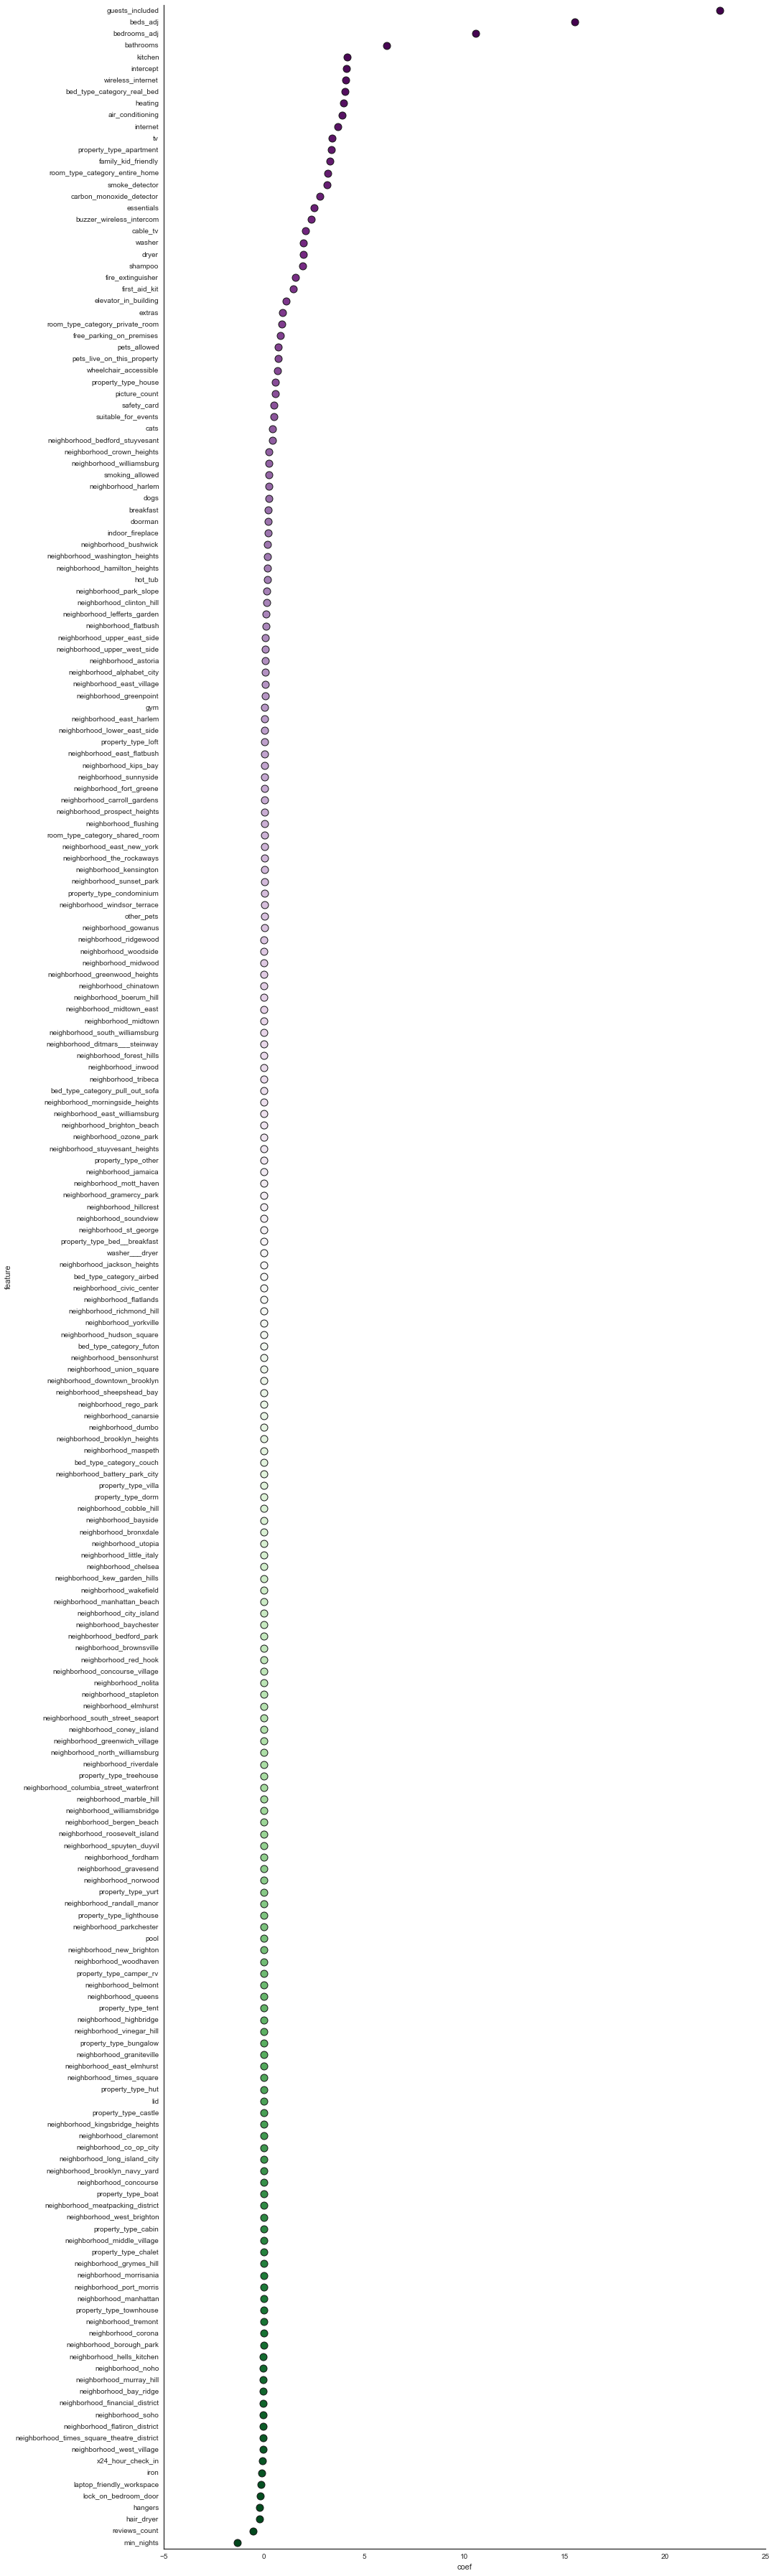

In [245]:
# Make the PairGrid
g = sns.PairGrid(coefs,
                 x_vars=['coef'], y_vars=["feature"],
                 size=50, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="PRGn", edgecolor="gray")

In [246]:
tents = query("SELECT lid, price FROM listings where property_type='Tent'")
tents

,lid,price
0,8522062,33
1,8522326,39
2,8928490,333
3,8539002,36
4,6315054,1099
5,4178830,100
6,8574451,33
7,3728552,250
8,4909388,65
9,8582786,39


In [247]:
from selenium import webdriver
lid = tents.loc[4, 'lid']
url = 'https://www.airbnb.com/rooms/{0}'.format(lid)
driver = webdriver.Chrome(executable_path='/opt/chromedriver')
driver.get(url)

In [248]:
lid = tents.loc[2, 'lid']
url = 'https://www.airbnb.com/rooms/{0}'.format(lid)
driver.get(url)

In [249]:
lid = tents.loc[7, 'lid']
url = 'https://www.airbnb.com/rooms/{0}'.format(lid)
driver.get(url)

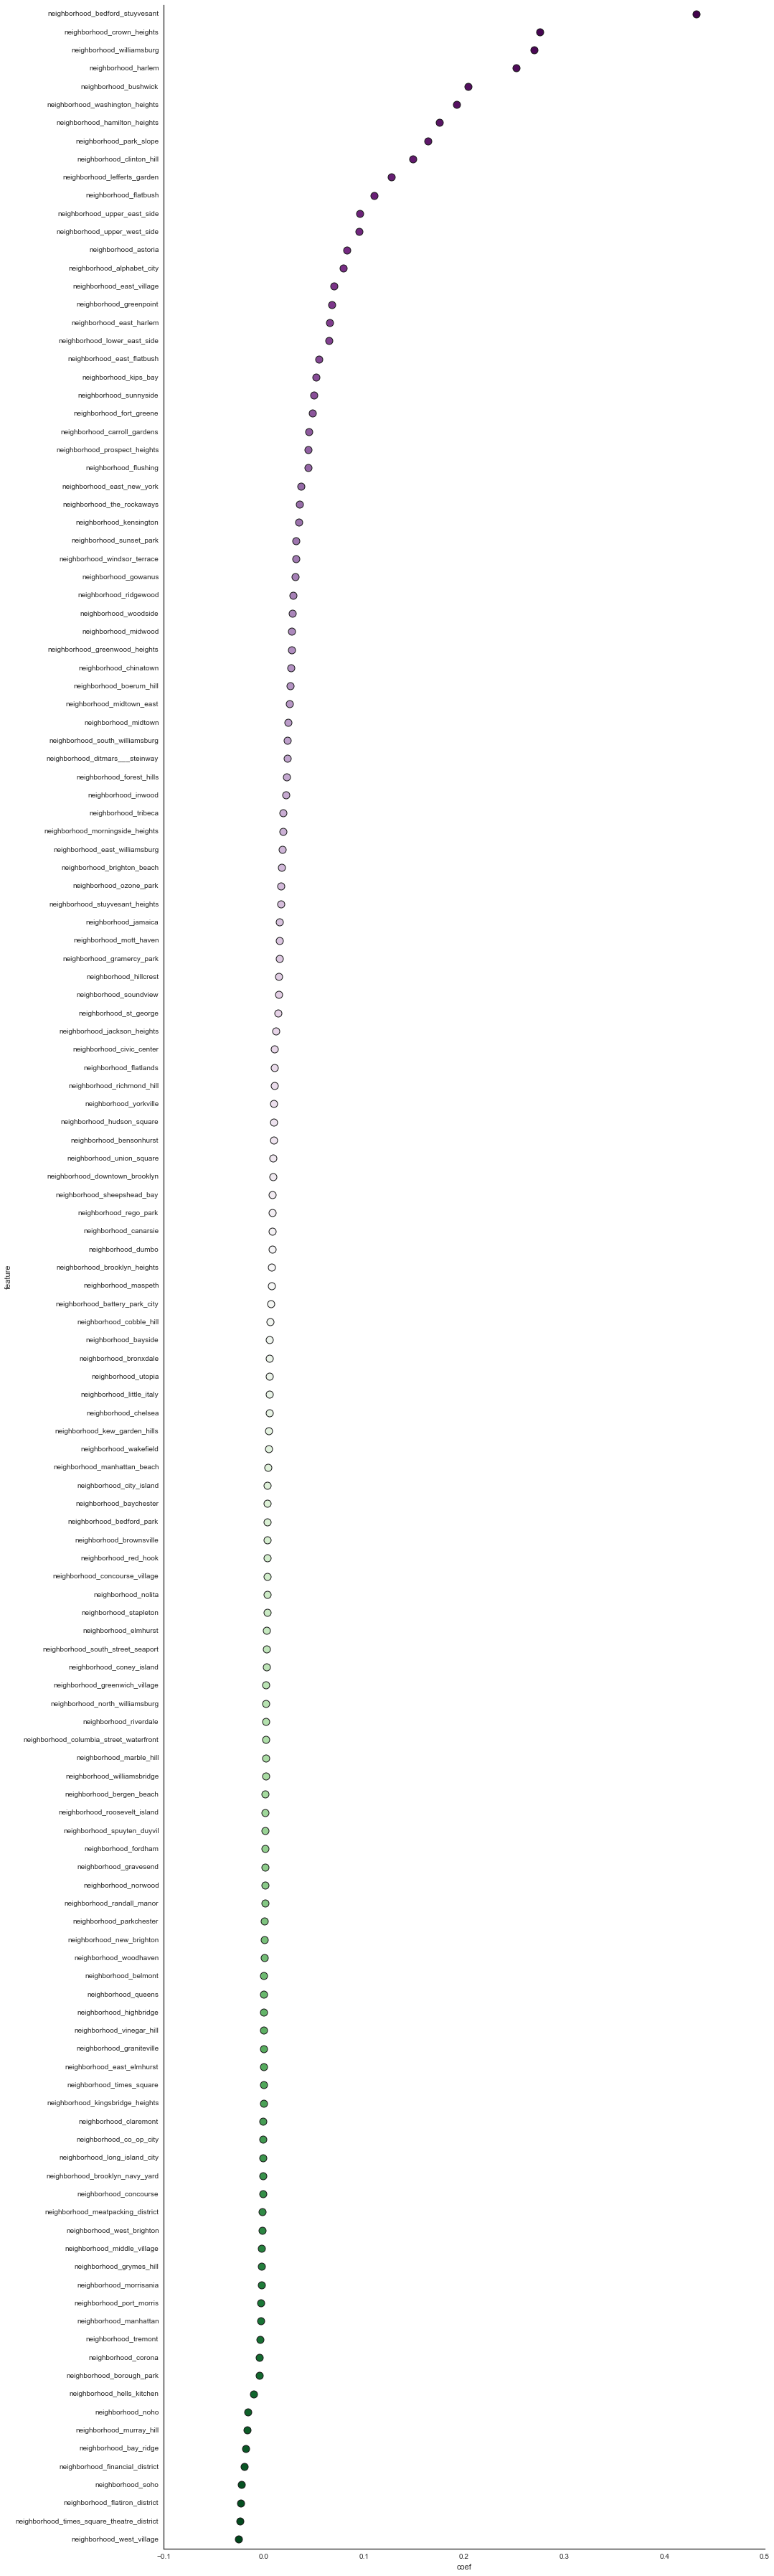

In [250]:
coefs_hood = coefs[coefs.feature_type == 'neighborhood']
g = sns.PairGrid(coefs_hood,
                 x_vars=['coef'], y_vars=["feature"],
                 size=50, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="PRGn", edgecolor="gray")

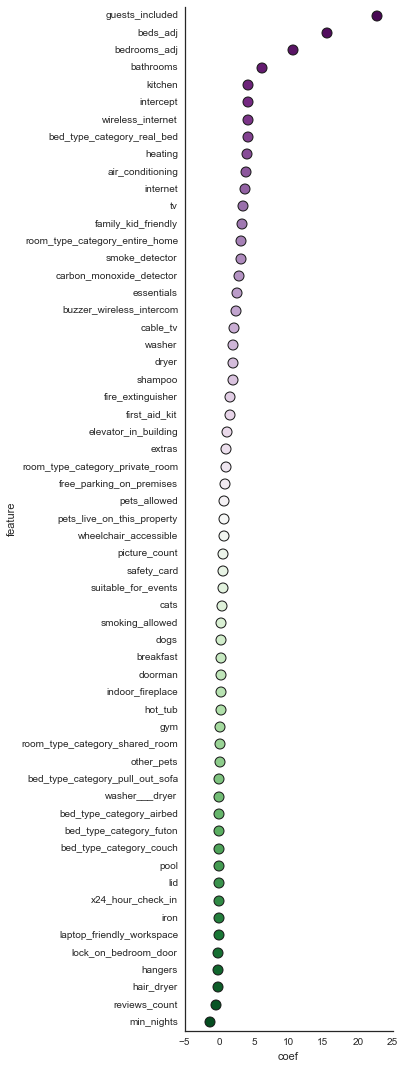

In [251]:
coefs_other = coefs[coefs.feature_type == 'other']
g = sns.PairGrid(coefs_other,
                 x_vars=['coef'], y_vars=["feature"],
                 size=15, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="PRGn", edgecolor="gray")

## Module 14: Scoring a test set

### working around some issues with null values being in the test set

In [252]:
df = query('SELECT * FROM dev.x00101_test_set LIMIT 1')
subq = 'SELECT '
subq += '\n'.join([', COALESCE({0},0) AS {0}'.format(c) for c in df.columns])[2:]
subq += '\n FROM dev.x00101_test_set'

### Prices and residuals using madlib.linregr_predict

In [259]:
q = """
SELECT test.lid, test.price,
       madlib.linregr_predict({1}, m.coef
       ) as prediction,
       price - madlib.linregr_predict({1}, m.coef
       ) as residual
FROM ({0}) test, dev.x01000_linreg m
""".format(subq, features)
df = query(q)

### Simple Root Mean Squared Error (RMSE)

* #### in Python (using the previous query)

In [260]:
df.head()

,lid,price,prediction,residual
0,7733315,119,135.741241,-16.741241
1,4325480,85,126.576669,-41.576669
2,105,899,132.440018,766.559982
3,4063357,125,160.598386,-35.598386
4,9699493,500,119.531284,380.468716


In [268]:
math.sqrt((df.residual**2).mean())

179.1908983804969

* #### in SQL

In [258]:
q = """
SELECT sqrt(avg((price - madlib.linregr_predict({1}, m.coef
       ))^2)) as RMSE
FROM ({0}) test, dev.x01000_linreg m
""".format(subq, features)
query(q).head()

,rmse
0,179.190898


## Module 15: tuning parameters

```sql
elastic_net_train( tbl_source,
                   tbl_result,
                   col_dep_var,
                   col_ind_var,
                   regress_family,
                   alpha,
                   lambda_value,
                   standardize,
                   grouping_col,
                   optimizer,
                   optimizer_params,
                   excluded,
                   max_iter,
                   tolerance
                 )
```

In [273]:
df = query('SELECT * FROM dev.x00100_train_set LIMIT 1')
q = 'CREATE TABLE dev.x00104_train_set_nonnull AS SELECT '
q += '\n'.join([', COALESCE({0},0) AS {0}'.format(c) for c in df.columns])[2:]
q += '\n FROM dev.x00100_train_set DISTRIBUTED RANDOMLY'
query(q)

psycopg2.ProgrammingError('no results to fetch')

### Elastic Net requires the data to be standardized
* #### MADlib has the option built-in, but we can implement it explicitly, either with pure SQL or PL/Python

### Reminder on PL/Python Syntax
```sql
CREATE OR REPLACE FUNCTION <name>(<parameter> <datatype>)
    RETURNS <return type>
AS
$$  
	<python code>
$$ 
LANGUAGE PLPYTHONU;```

In [419]:
query(["""
DROP FUNCTION dev.standardize(float[])
""",
"""
CREATE OR REPLACE FUNCTION dev.standardize(vec float[])
    RETURNS float[]
AS
$$  
    import numpy as np
    v = np.array(vec)
    u = v.mean()
    s = v.std()
    return (v - u)/(2 * s)
$$
LANGUAGE PLPYTHONU
"""], False)

### Steps to standardize a column:
* #### cast as float (so we can use one generic function)
* #### put the column into an array_agg (essentially a column vector)
* #### what's the downside of this approach?

In [420]:
query("""
SELECT dev.standardize(array_agg(air_conditioning::float))
FROM dev.x00104_train_set_nonnull
""")

,standardize
0,"[0.22435024087, 0.22435024087, 0.22435024087, ..."


In [423]:
query("""
SELECT dev.standardize(array_agg(air_conditioning::float)) AS air_conditioning
  , dev.standardize(array_agg(bathrooms::float)) AS bathrooms
FROM dev.x00104_train_set_nonnull
""")

,air_conditioning,bathrooms
0,"[0.22435024087, 0.22435024087, 0.22435024087, ...","[-0.144214481501, -0.144214481501, -0.14421448..."


In [429]:
query("""
SELECT UNNEST(air_conditioning) as air_conditioning
    , UNNEST(bathrooms) as bathrooms FROM
(SELECT dev.standardize(array_agg(air_conditioning::float)) AS air_conditioning
  , dev.standardize(array_agg(bathrooms::float)) AS bathrooms
FROM dev.x00104_train_set_nonnull) q
""").head(20)

,unnest,unnest
0,0.224350,-0.144214
1,0.224350,-0.144214
2,0.224350,-0.144214
3,0.224350,-0.144214
4,0.224350,-0.144214
5,0.224350,-0.144214
6,0.224350,-0.144214
7,0.224350,-0.144214
8,0.224350,-0.144214
9,0.224350,-0.144214


#### Iterate over all the columns to standardize each

In [437]:
all_cols = [c for c in query('SELECT * FROM dev.x00104_train_set_nonnull LIMIT 1').columns \
               if c != 'lid']

In [442]:
%%time
q = 'CREATE TABLE dev.x00105_train_set_stdized \n'
q += 'AS SELECT ' 
q += '\n'.join([', UNNEST({0}) AS {0}'.format(c) for c in all_cols])[2:]
q += '\n FROM (SELECT \n' 
q += '\n'.join([', dev.standardize(array_agg({0}::float)) AS {0}'.format(c) for c in all_cols])[2:]
q += '\n FROM dev.x00104_train_set_nonnull) q'
query(['DROP TABLE IF EXISTS dev.x00105_train_set_stdized CASCADE', q])

CPU times: user 14.3 ms, sys: 10.1 ms, total: 24.5 ms
Wall time: 9min 18s


In [451]:
df = query('SELECT * FROM dev.x00105_train_set_stdized LIMIT 1')
cols = str(sorted([c for c in df.columns if c not in ['lid', 'price']]))
features = 'ARRAY[1, ' + cols.replace("'",'')[1:]

for alpha in [0, 0.5, 1.0]:
    for l in [3, 2, 1, 0, -1, -2]:
        q = ["""
        DROP TABLE IF EXISTS dev.x01001_linreg_regularized_{0}__{1}
        """.format(str(alpha).replace('.','_'), str(10**l).replace('.','_')), 
        """
        SELECT madlib.elastic_net_train( 'dev.x00105_train_set_stdized',
                 'dev.x01001_linreg_regularized_{3}__{4}',
                 'price',
                 '{0}',
                 'gaussian',
                 {1},
                 {2},
                 FALSE,
                 NULL,
                 'fista',
                 '',
                 NULL,
                 10000,
                 1e-6
               )
        """.format(features, alpha, 10**l, str(alpha).replace('.','_'), str(10**l).replace('.','_'))]
        %time query(q)
        sys.stderr.write(str(alpha) + ',' + str(l) + '\n')

CPU times: user 190 ms, sys: 137 ms, total: 327 ms
Wall time: 2h 28min 36s
CPU times: user 4.39 ms, sys: 2.52 ms, total: 6.92 ms

0,3
0,2



Wall time: 2min 11s
CPU times: user 2.82 ms, sys: 1.45 ms, total: 4.27 ms
Wall time: 1min 5s
CPU times: user 1.95 ms, sys: 806 µs, total: 2.76 ms

0,1
0,0



Wall time: 36.9 s
CPU times: user 1.79 ms, sys: 816 µs, total: 2.6 ms
Wall time: 33.2 s
CPU times: user 2.01 ms, sys: 782 µs, total: 2.79 ms

0,-1
0,-2



Wall time: 32.5 s
CPU times: user 925 µs, sys: 273 µs, total: 1.2 ms
Wall time: 5.95 s
CPU times: user 1.19 ms, sys: 486 µs, total: 1.68 ms

0.5,3
0.5,2



Wall time: 5.5 s
CPU times: user 1.19 ms, sys: 310 µs, total: 1.5 ms
Wall time: 5.5 s
CPU times: user 1.09 ms, sys: 453 µs, total: 1.54 ms

0.5,1
0.5,0



Wall time: 6.23 s
CPU times: user 1.53 ms, sys: 548 µs, total: 2.07 ms
Wall time: 20.9 s
CPU times: user 1.98 ms, sys: 797 µs, total: 2.78 ms

0.5,-1
0.5,-2



Wall time: 36 s
CPU times: user 1.17 ms, sys: 329 µs, total: 1.49 ms
Wall time: 5.48 s
CPU times: user 1.17 ms, sys: 351 µs, total: 1.52 ms

1.0,3
1.0,2



Wall time: 5.12 s
CPU times: user 1.17 ms, sys: 311 µs, total: 1.49 ms
Wall time: 5.78 s
CPU times: user 1.13 ms, sys: 289 µs, total: 1.42 ms

1.0,1
1.0,0



Wall time: 5.34 s
CPU times: user 1.24 ms, sys: 316 µs, total: 1.55 ms
Wall time: 7.66 s
CPU times: user 2.23 ms, sys: 928 µs, total: 3.16 ms

1.0,-1
1.0,-2



Wall time: 44.5 s


In [454]:
elastic_net_results = {}
for alpha in [0, 0.5, 1.0]:
    elastic_net_results[alpha] = {}
    for l in [3, 2, 1, 0, -1, -2]:
        q = ["""
        SELECT * FROM dev.x01001_linreg_regularized_{0}__{1}
        """.format(str(alpha).replace('.','_'), str(10**l).replace('.','_'))]
        elastic_net_results[alpha][l] = query(q)

In [473]:
for alpha in [0, 0.5, 1.0]:
    for l in [3, 2, 1, 0, -1, -2]:
        print 'alpha={0}, lambda={1}, nonzero_coef={2}'.format(alpha, l, \
                    len(list(elastic_net_results[alpha][l].coef_nonzero)[0]))

alpha=0, lambda=3, nonzero_coef=217
alpha=0, lambda=2, nonzero_coef=217
alpha=0, lambda=1, nonzero_coef=217
alpha=0, lambda=0, nonzero_coef=217
alpha=0, lambda=-1, nonzero_coef=217
alpha=0, lambda=-2, nonzero_coef=217
alpha=0.5, lambda=3, nonzero_coef=0
alpha=0.5, lambda=2, nonzero_coef=0
alpha=0.5, lambda=1, nonzero_coef=0
alpha=0.5, lambda=0, nonzero_coef=0
alpha=0.5, lambda=-1, nonzero_coef=5
alpha=0.5, lambda=-2, nonzero_coef=61
alpha=1.0, lambda=3, nonzero_coef=0
alpha=1.0, lambda=2, nonzero_coef=0
alpha=1.0, lambda=1, nonzero_coef=0
alpha=1.0, lambda=0, nonzero_coef=0
alpha=1.0, lambda=-1, nonzero_coef=0
alpha=1.0, lambda=-2, nonzero_coef=27


In [474]:
elastic_net_results[1][-2]

,family,features,features_selected,coef_nonzero,coef_all,intercept,log_likelihood,standardize,iteration_run
0,gaussian,"[1, air_conditioning, bathrooms, bed_type_cate...","[bathrooms, bedrooms_adj, beds_adj, cable_tv, ...","[0.169754072827, 0.078126027211, 0.00572285101...","[0.0, 0.0, 0.169754072827, 0.0, 0.0, 0.0, 0.0,...",-5.435839e-14,-0.101042,False,46


## Module 16: What we didn't get to cover that I originally hoped to

### i.e. some things you can try

* ### Pooling vs. no pooling vs. partial pooling

* ### Text analytics 
 * #### NLTK with PL/Python
 * #### LDA and other algorithms in MADlib

* ### Cluster neighborhoods

* ### Training Models in PL/Python 
 * #### how to work with arrays, array_aggregates, custom_aggregates for passing matrices
 * #### scikit-learn for training models, grid search, sampling
 * #### popular models that we can use to extend scikit-learn, e.g. gradient boosted trees
 * #### parallelism with PL/Python

* ### dask and blaze

* ### todo: compare time for external table to internal table
* ### PL/Python function to standardize (repeatable)
* ### pgSQL function to repeat CV split (maybe return the right number of folds ... standardize table names to do k-fold CV)
* ### also try out MADlib's CV function